## Setup

### Essential Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

### PandasAI

In [2]:
# import os
# from dotenv import load_dotenv

# load_dotenv()
# openai_api_token = os.getenv('openai_api_token')

In [3]:
# from pandasai.llm import OpenAI
# from pandasai import SmartDataframe

# llm = OpenAI(api_token=openai_api_token) # replace your openai api token here

data = pd.read_csv('datasets/2024_LoL_esports_match_data_from_OraclesElixir_gamedata.csv', sep=',')
# sdf = SmartDataframe(data, config = {'llm': llm})

# response = sdf.chat("""what is some interesting questions i can use for eda from this data set""")
# response = sdf.chat("""Predict the win rate of a team based on the champion's class and position.""")
# response = sdf.chat("""Create the code for a linear regression with 't1p1_champion', 't1p2_champion', 't1p3_champion', 't1p4_champion', 't1p5_champion' as team1 and 't2p1_champion', 't2p2_champion', 't2p3_champion', 't2p4_champion', 't2p5_champion' as team2 that predict the win rate""")
# print(response)
# print(sdf.last_code_generated)

---

In [4]:
all_data = pd.read_csv('datasets/2024_LoL_esports_match_data_from_OraclesElixir_gamedata.csv', sep=',')
all_data.head()

,gameid,datacompleteness,league,year,split,playoffs,date,game,patch,gamelength,...,t2p5_deathsat10,t2p5_goldat15,t2p5_xpat15,t2p5_csat15,t2p5_golddiffat15,t2p5_xpdiffat15,t2p5_csdiffat15,t2p5_killsat15,t2p5_assistsat15,t2p5_deathsat15
0,10660-10660_game_3,partial,DCup,2023,NaN,0,1/1/2024 6:54,3,13.24,1324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LOLTMNT05_13659,complete,LPLOL,2024,Spring,0,26/1/2024 19:10,1,14.01,1364,...,2.0,3666.0,3845.0,22.0,-1115.0,494.0,10.0,0.0,1.0,3.0
2,LOLTMNT04_24264,complete,LEC,2024,Winter,1,3/2/2024 18:47,2,14.02,1350,...,0.0,3692.0,3499.0,14.0,-1090.0,-1025.0,-22.0,1.0,0.0,2.0
3,LOLTMNT01_52094,complete,ESLOL,2024,Spring,0,8/2/2024 19:11,1,14.02,1357,...,0.0,3915.0,3670.0,17.0,-398.0,-290.0,-1.0,1.0,2.0,1.0
4,LOLTMNT02_29074,complete,LCK,2024,Spring,0,24/1/2024 9:00,2,14.01,1283,...,0.0,3738.0,3962.0,22.0,-711.0,-431.0,-29.0,0.0,1.0,1.0


In [5]:
# 2024_LoL_esports_match_data_from_OraclesElixir_gamedata_v4.csv
loldata = pd.read_csv('datasets/2024_LoL_esports_match_data_from_OraclesElixir_gamedata.csv', sep=',')
lolData_Qtn1_Columns = ['t1_result','t2_result','gamelength','t1p1_champion','t1p2_champion','t1p3_champion','t1p4_champion','t1p5_champion','t2p1_champion','t2p2_champion','t2p3_champion','t2p4_champion','t2p5_champion']
loldataQtn1 = loldata[lolData_Qtn1_Columns].copy()

# LOL-Champions.csv
lolChampdata = pd.read_csv('datasets/LoL-Champions.csv')
lolChampdata_ChampName_TagName = lolChampdata[['Name', 'Class']]

# Assuming 'loldata' is the name of your DataFrame
dfsA = ['t1p1_champion','t1p2_champion','t1p3_champion','t1p4_champion','t1p5_champion']
dfsAA = ['t2p1_champion','t2p2_champion','t2p3_champion','t2p4_champion','t2p5_champion']

# Filter rows where t1_result is 1 for Team 1 and t2_result is 1 for Team 2
winning_compositions_t1 = loldataQtn1[loldataQtn1['t1_result'] == 1]
winning_compositions_t2 = loldataQtn1[loldataQtn1['t2_result'] == 1]

dfsns = winning_compositions_t1[dfsA].copy()
dfsC= winning_compositions_t2[dfsAA].copy()

# Rename the columns of specific_columns_team1 and specific_columns_team2
dfsns.columns = ['P1 Top', 'P2 Jungle', 'P3 Mid', 'P4 Bot', 'P5 Support']
dfsC.columns = ['P1 Top', 'P2 Jungle', 'P3 Mid', 'P4 Bot', 'P5 Support']

combined_dataframe = pd.concat([dfsns, dfsC], ignore_index=True)

---

## Exploration - Which champion team composition has the high chance of winning? (Association)

To do so, we have combined the data sets from the Game Match Dataset and Champion Info Dataset and filtered it out to only take in teams that won.

We then further merged the classes for each champion and inputted them in the dataframe. (e.g P1 Top (Name of Champion) P1 Top Class (Class type of champion))

In [6]:
# Assuming you have loaded Dataset1 and Dataset2 into pandas DataFrames

# Perform left join
merged_data = pd.merge(combined_dataframe, lolChampdata_ChampName_TagName, left_on='P1 Top', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'P1 Top Class'}, inplace=True)

merged_data = pd.merge(merged_data, lolChampdata_ChampName_TagName, left_on='P2 Jungle', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'P2 Jungle Class'}, inplace=True)

merged_data = pd.merge(merged_data, lolChampdata_ChampName_TagName, left_on='P3 Mid', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'P3 Mid Class'}, inplace=True)

# Drop the redundant 'Name' columns
merged_data.drop(columns=['Name_x', 'Name_y'], inplace=True)

merged_data = pd.merge(merged_data, lolChampdata_ChampName_TagName, left_on='P4 Bot', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'P4 Bot Class'}, inplace=True)

merged_data.drop(columns=['Name_x', 'Name_y'], inplace=True)

merged_data = pd.merge(merged_data, lolChampdata_ChampName_TagName, left_on='P5 Support', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'P5 Support Class'}, inplace=True)

merged_data.drop(columns=['Name'], inplace=True)

desired_columns_order = ['P1 Top', 'P1 Top Class', 'P2 Jungle', 'P2 Jungle Class', 'P3 Mid', 'P3 Mid Class', 'P4 Bot','P4 Bot Class','P5 Support','P5 Support Class']

# Reorder the columns
merged_data = merged_data[desired_columns_order]

# Display the resulting DataFrame
display(merged_data)



,P1 Top,P1 Top Class,P2 Jungle,P2 Jungle Class,P3 Mid,P3 Mid Class,P4 Bot,P4 Bot Class,P5 Support,P5 Support Class
0,Jax,Warrior,Bel'Veth,Warrior,Neeko,Mage,Caitlyn,Marksman,Lux,Mage
1,Udyr,Warrior,Xin Zhao,Warrior,Azir,Mage,Kalista,Marksman,Renata Glasc,Support
2,Zac,Tank-Warrior,Vi,Warrior,Azir,Mage,Senna,Marksman-Support,Maokai,Tank
3,Aatrox,Warrior,Jax,Warrior,Hwei,Mage,Kalista,Marksman,Nautilus,Tank-Support
4,Rumble,Mage-Warrior,Maokai,Tank,Tristana,Marksman,Lucian,Marksman,Milio,Support
...,...,...,...,...,...,...,...,...,...,...
1018,Yone,Warrior,Jax,Warrior,LeBlanc,Mage-Assassin,Xayah,Marksman,Nautilus,Tank-Support
1019,Gnar,Warrior,Rell,Tank-Support,Kai'Sa,Marksman,Varus,Marksman,Renata Glasc,Support
1020,K'Sante,Tank-Warrior,Maokai,Tank,LeBlanc,Mage-Assassin,Kalista,Marksman,Zyra,Mage-Support
1021,K'Sante,Tank-Warrior,Lee Sin,Warrior-Assassin,Azir,Mage,Senna,Marksman-Support,Nautilus,Tank-Support


Here is the prepared data frame after doing the successfuly merging. 

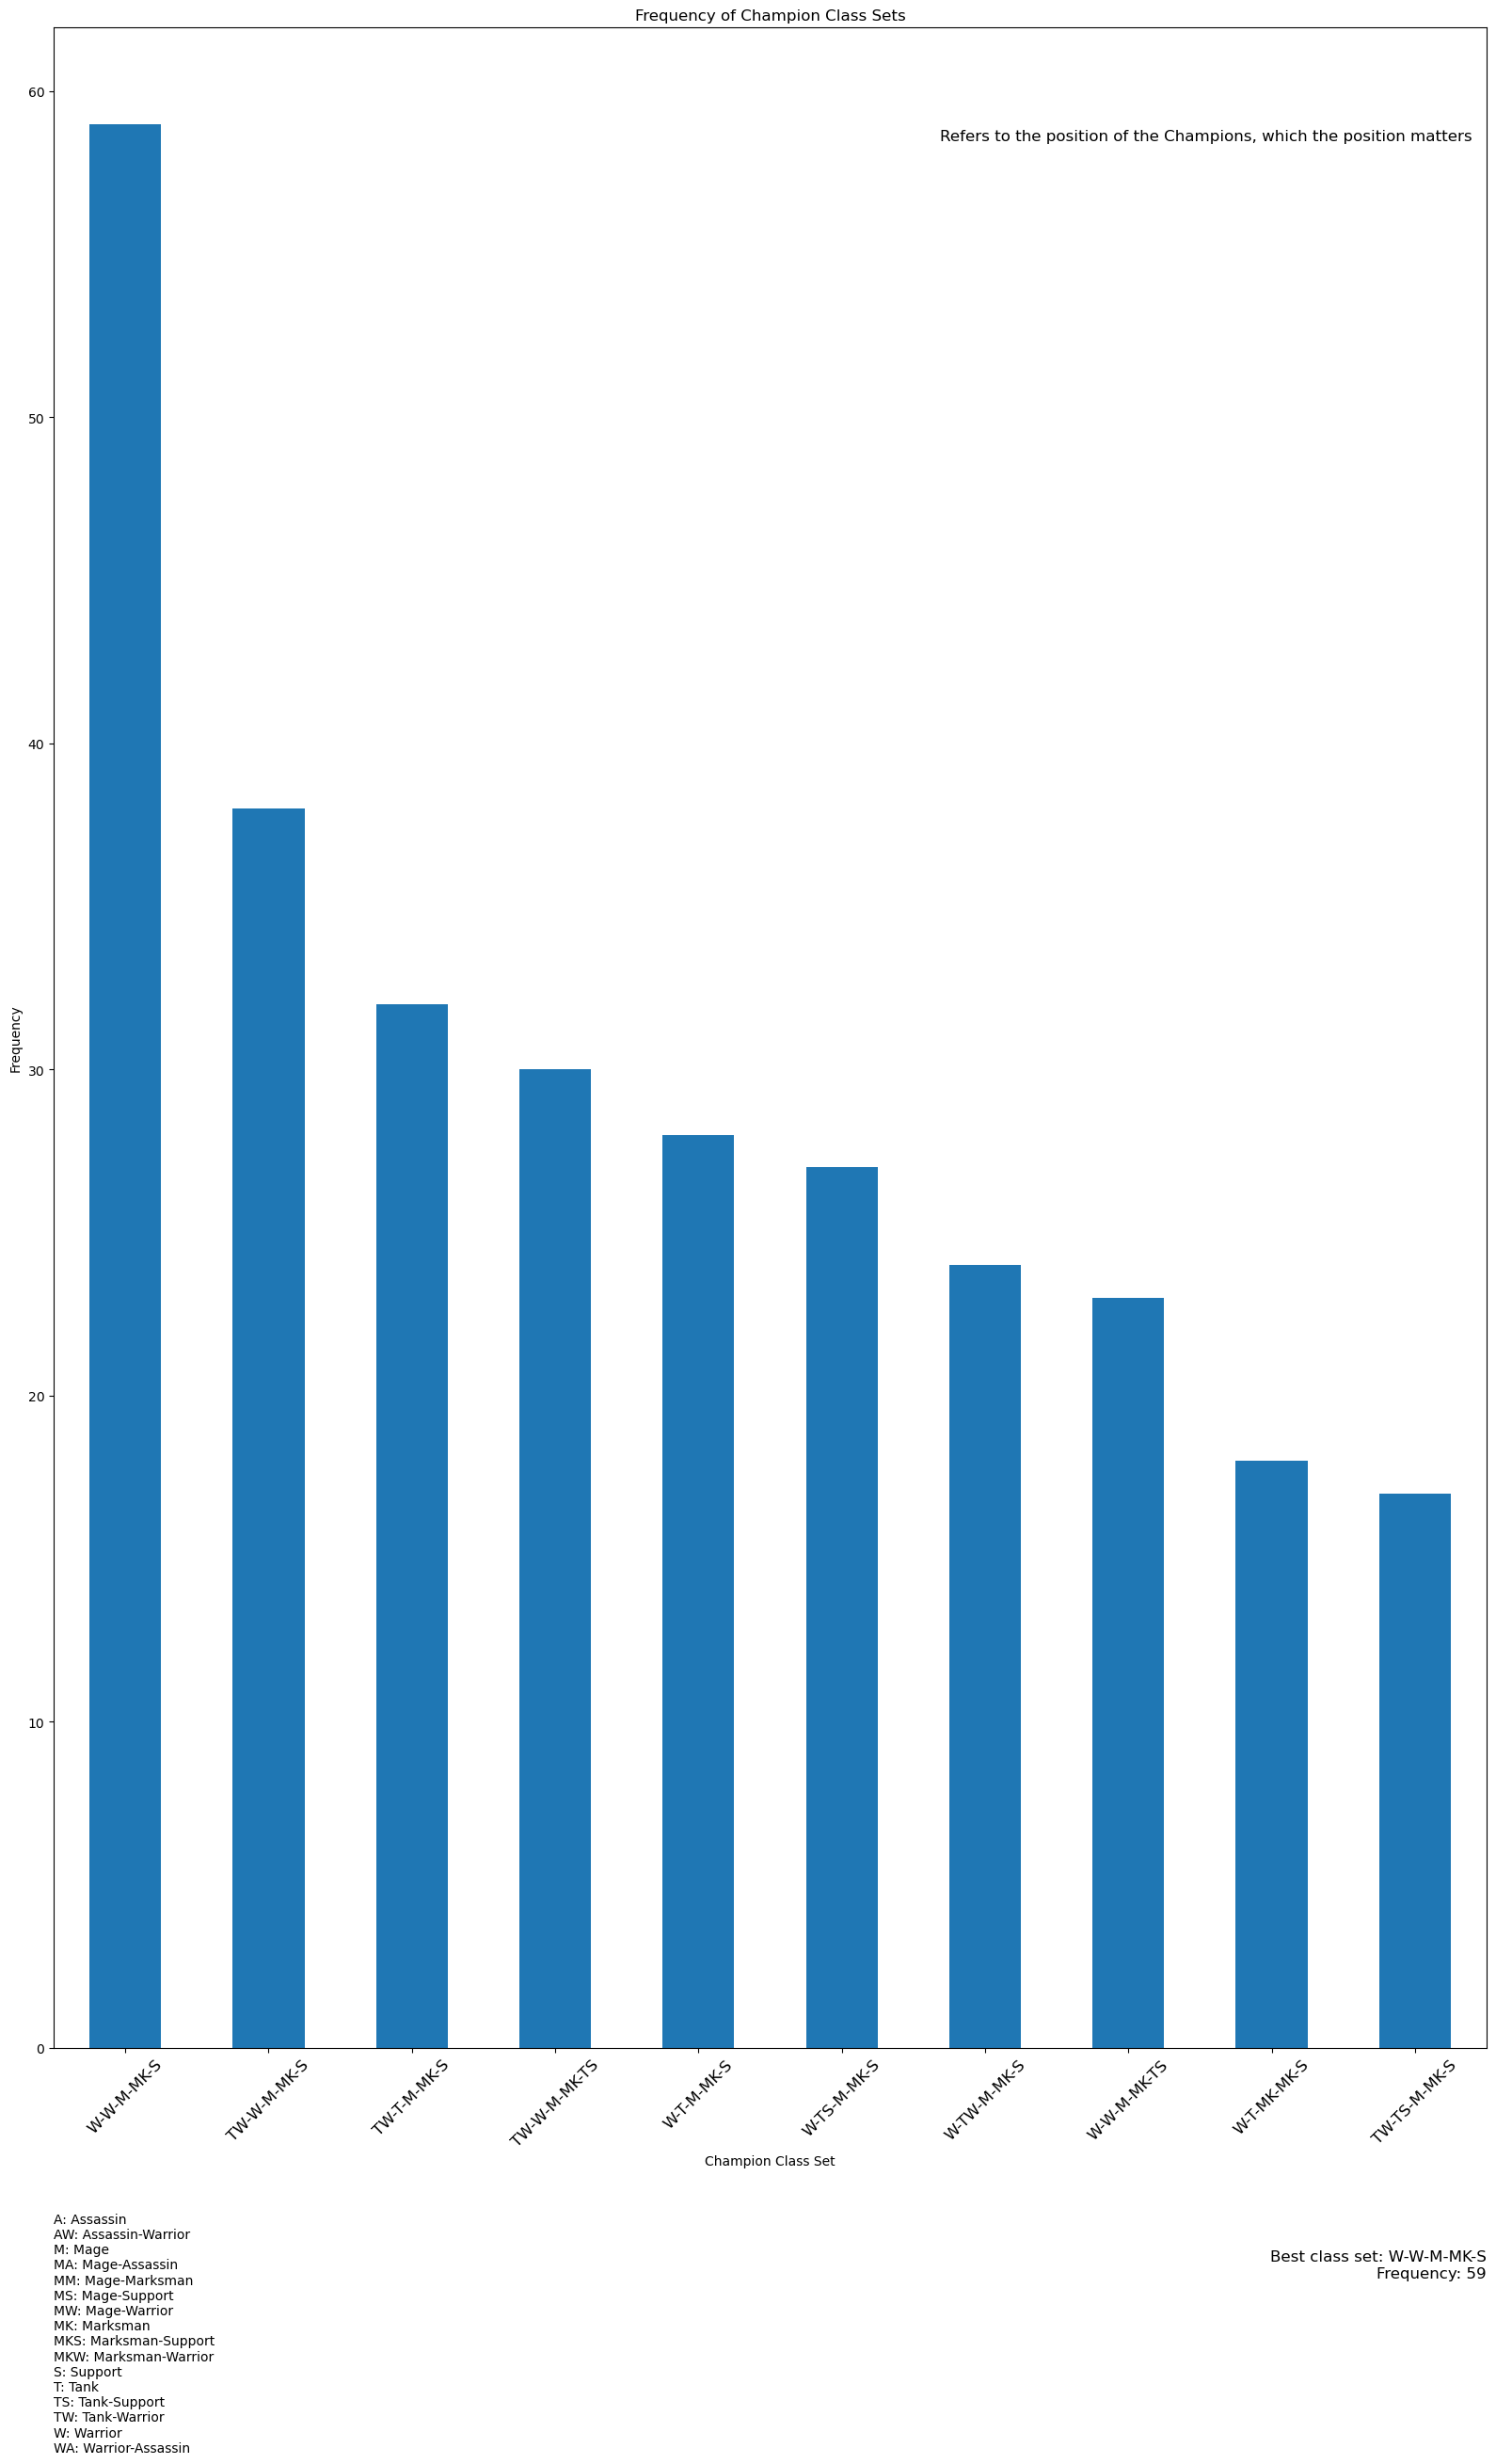

In [7]:
# Define the dataframe with team compositions
data = merged_data[['P1 Top Class', 'P2 Jungle Class', 'P3 Mid Class', 'P4 Bot Class', 'P5 Support Class']]
dfs = pd.DataFrame(data)
# Fill any NaN values with a placeholder string
dfs = dfs.fillna('Unknown')

# Convert all values to strings
dfs = dfs.astype(str)

# Mapping dictionary to replace class names with letters
class_mapping = {
    'Assassin': 'A',
    'Assassin-Warrior': 'AW',
    'Mage': 'M',
    'Mage-Assassin': 'MA',
    'Mage-Marksman': 'MM',
    'Mage-Support': 'MS',
    'Mage-Warrior': 'MW',
    'Marksman': 'MK',
    'Marksman-Support': 'MKS',
    'Marksman-Warrior': 'MKW',
    'Support': 'S',
    'Tank': 'T',
    'Tank-Support': 'TS',
    'Tank-Warrior': 'TW',
    'Warrior': 'W',
    'Warrior-Assassin': 'WA'
}

# Dictionary to map class abbreviations back to full names
class_mapping_reverse = {v: k for k, v in class_mapping.items()}

# Rename class columns with letters
for col in dfs.columns:
    dfs[col] = dfs[col].map(class_mapping)

# Concatenate the class columns to create a new column representing the class set
dfs['Class_Set'] = dfs.apply(lambda row: '-'.join(row), axis=1)

# Count the occurrences of each class set
top_class_sets = dfs['Class_Set'].value_counts().head(10)

# Plotting
plt.figure(figsize=(16, 26))  # Increase the height to accommodate the label below
top_class_sets.plot(kind='bar')
plt.title('Frequency of Champion Class Sets')
plt.xlabel('Champion Class Set')
plt.ylabel('Frequency')
plt.xticks(rotation=45, fontsize=12)  # Adjust the rotation and fontsize as needed

# Display class_mapping_reverse at the bottom left of the plot
table_text = '\n'.join([f'{abbr}: {full}' for abbr, full in class_mapping_reverse.items()])
plt.text(0, -0.2, table_text, ha='left', fontsize=10, transform=plt.gca().transAxes)

# Find the class set with the highest frequency
best_class_set = top_class_sets.idxmax()
best_frequency = top_class_sets.max()

# Add text on the top right
bot_right_text = f'Best class set: {best_class_set}\nFrequency: {best_frequency}'
plt.text(1, -0.1, bot_right_text, ha='right', va='top', fontsize=12, transform=plt.gca().transAxes)

top_right_text = f'Refers to the position of the Champions, which the position matters'
plt.text(0.99, 0.95, top_right_text, ha='right', va='top', fontsize=12, transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

#### The best champion class set is: W-W-M-MK-S
#### Frequency of occurrence: 59

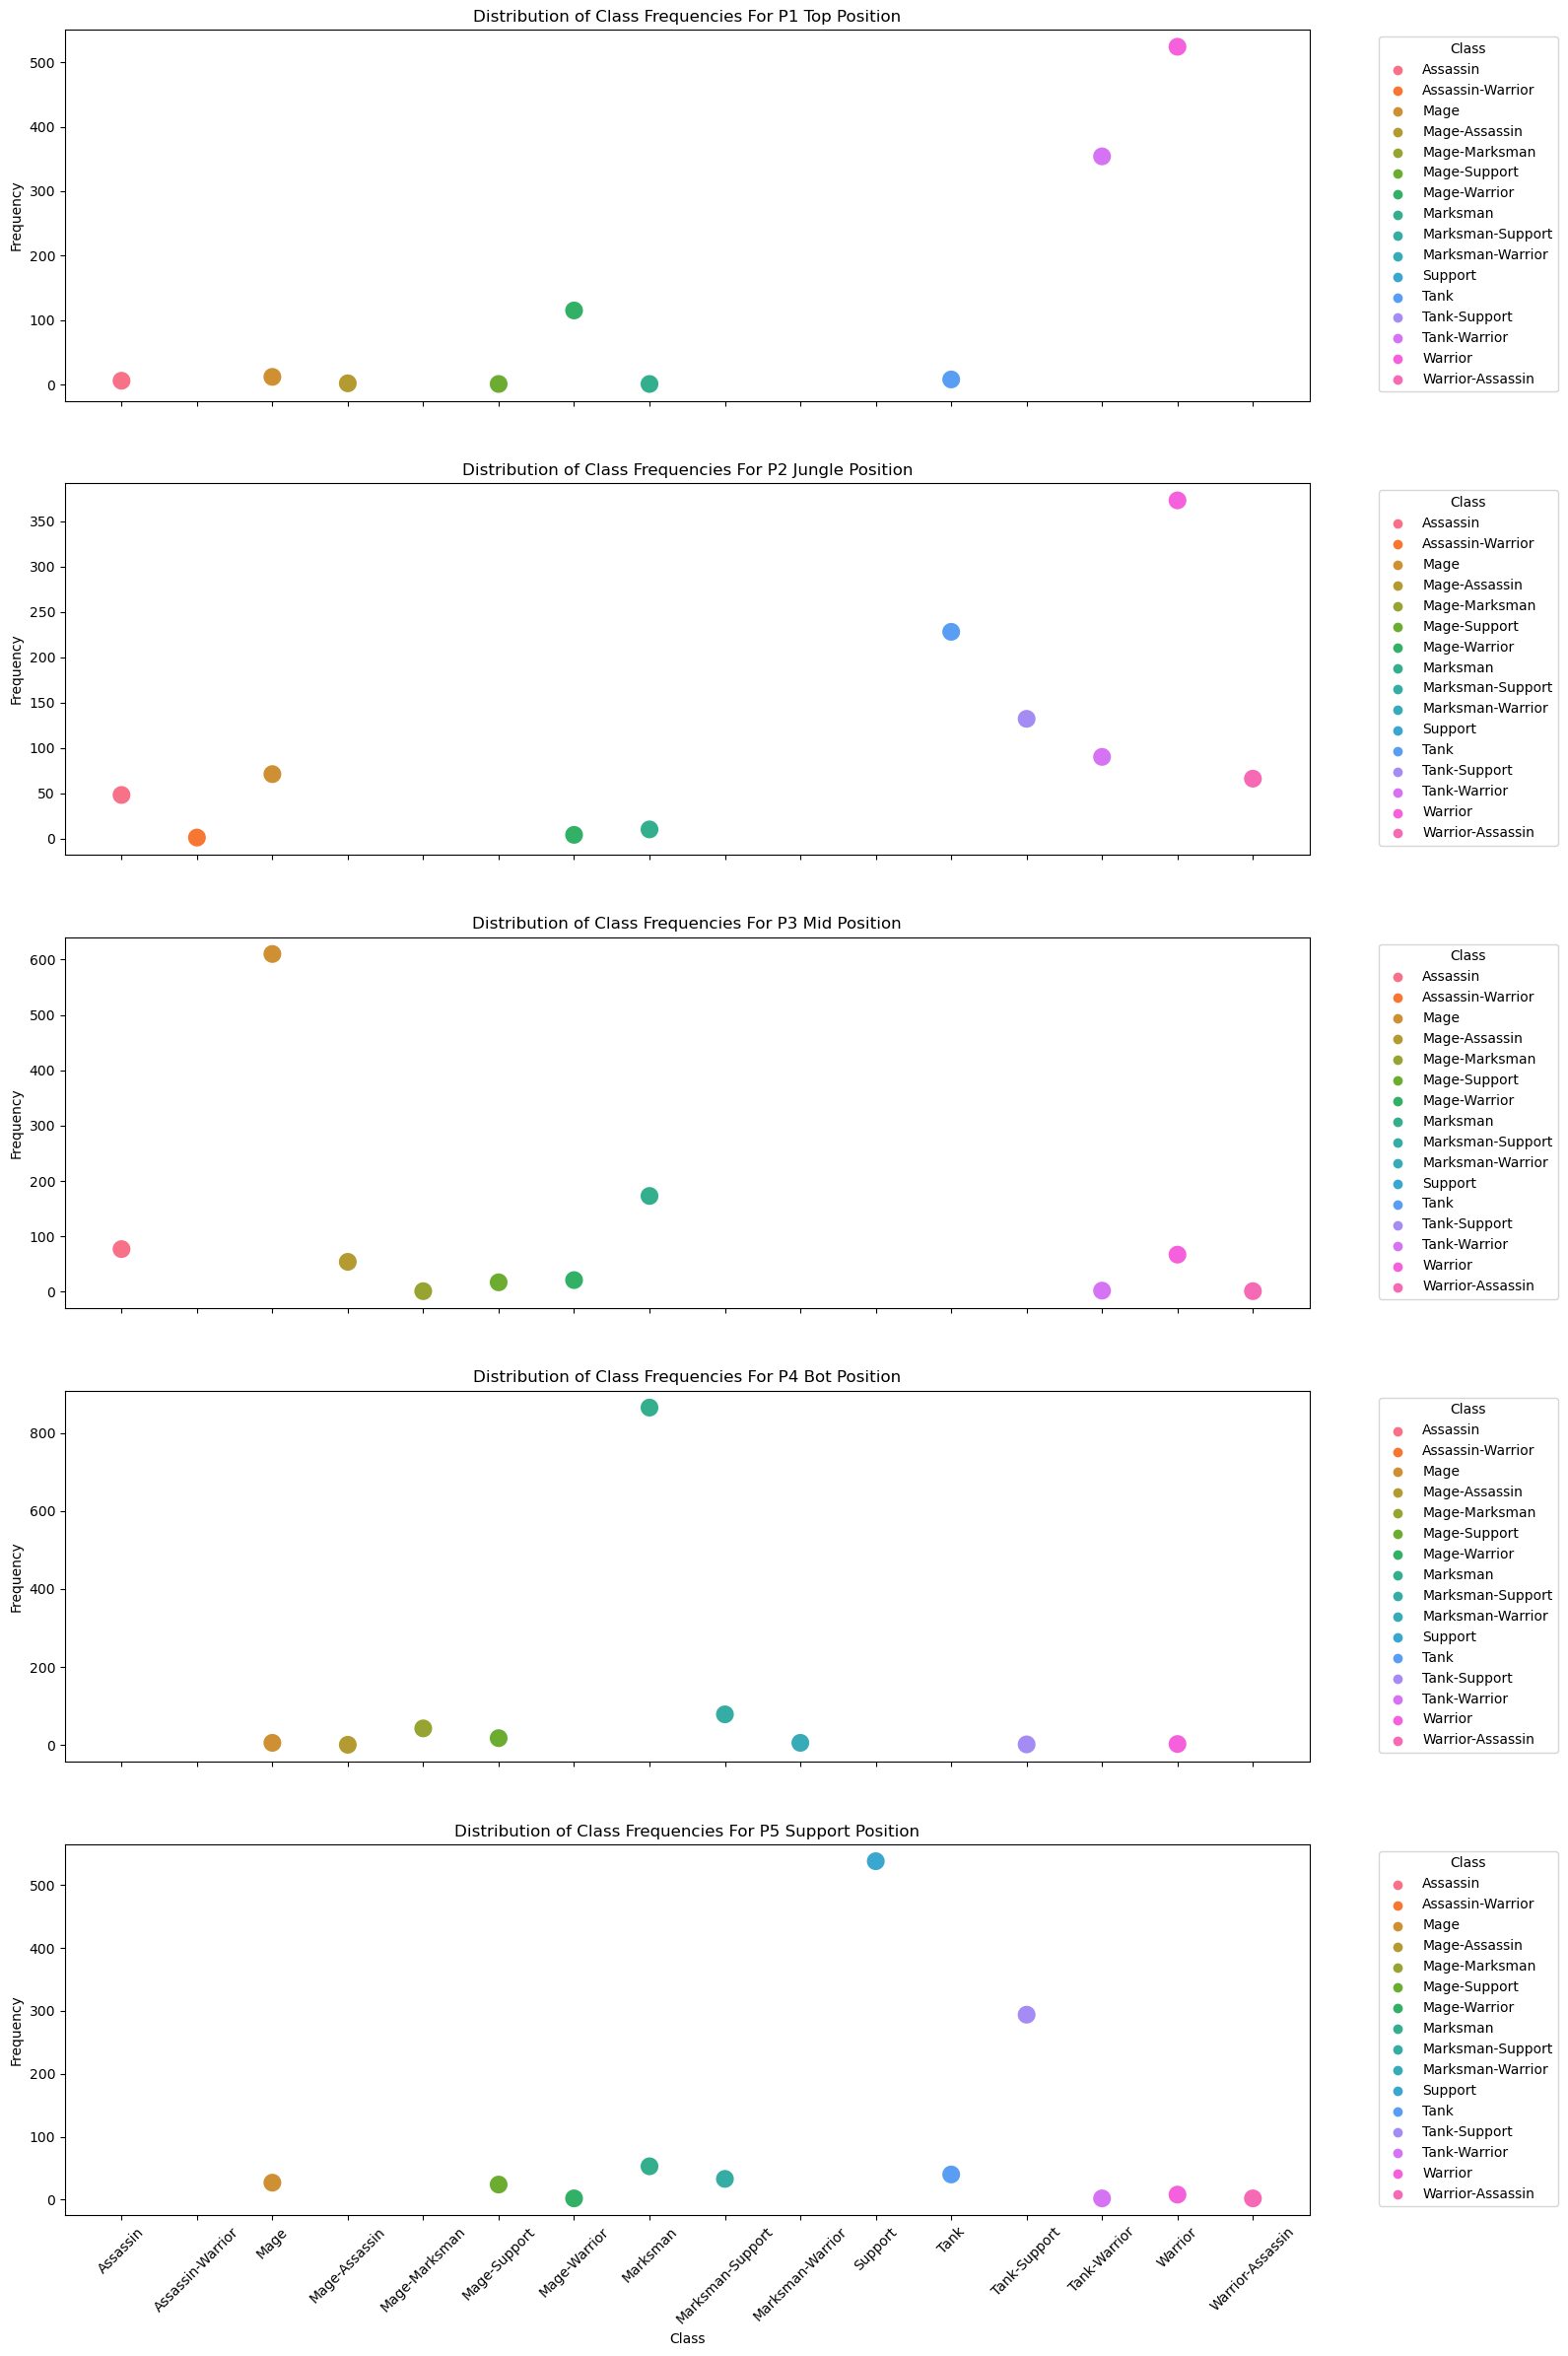

In [8]:

# data = merged_data[['P1 Top Class', 'P2 Jungle Class', 'P3 Mid Class', 'P4 Bot Class', 'P5 Support Class']]

df = pd.DataFrame(data)

# Calculate class frequencies for each position
class_frequencies = df.apply(pd.Series.value_counts)

# Transpose the DataFrame for better visualization
class_frequencies = class_frequencies.T

# Reset index to make position a column instead of index
class_frequencies.reset_index(inplace=True)

# Melt the DataFrame to convert it to long format for plotting
class_frequencies_melted = pd.melt(class_frequencies, id_vars=['index'], var_name='Class', value_name='Frequency')

# Filter data for each position
df_p1 = class_frequencies_melted[class_frequencies_melted['index'] == 'P1 Top Class']
df_p2 = class_frequencies_melted[class_frequencies_melted['index'] == 'P2 Jungle Class']
df_p3 = class_frequencies_melted[class_frequencies_melted['index'] == 'P3 Mid Class']
df_p4 = class_frequencies_melted[class_frequencies_melted['index'] == 'P4 Bot Class']
df_p5 = class_frequencies_melted[class_frequencies_melted['index'] == 'P5 Support Class']

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(16, 24), sharex=True)

# Plot for P1 Top Class
sns.scatterplot(data=df_p1, x='Class', y='Frequency', hue='Class', s=200, ax=axes[0])
axes[0].set_title('Distribution of Class Frequencies For P1 Top Position')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# Plot for P2 Jungle Class
sns.scatterplot(data=df_p2, x='Class', y='Frequency', hue='Class', s=200, ax=axes[1])
axes[1].set_title('Distribution of Class Frequencies For P2 Jungle Position')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

# Plot for P3 Mid Class
sns.scatterplot(data=df_p3, x='Class', y='Frequency', hue='Class', s=200, ax=axes[2])
axes[2].set_title('Distribution of Class Frequencies For P3 Mid Position')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Frequency')
axes[2].legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2].tick_params(axis='x', rotation=45)

# Plot for P4 Bot Class
sns.scatterplot(data=df_p4, x='Class', y='Frequency', hue='Class', s=200, ax=axes[3])
axes[3].set_title('Distribution of Class Frequencies For P4 Bot Position')
axes[3].set_xlabel('Class')
axes[3].set_ylabel('Frequency')
axes[3].legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[3].tick_params(axis='x', rotation=45)

# Plot for P5 Support Class
sns.scatterplot(data=df_p5, x='Class', y='Frequency', hue='Class', s=200, ax=axes[4])
axes[4].set_title('Distribution of Class Frequencies For P5 Support Position')
axes[4].set_xlabel('Class')
axes[4].set_ylabel('Frequency')
axes[4].legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[4].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

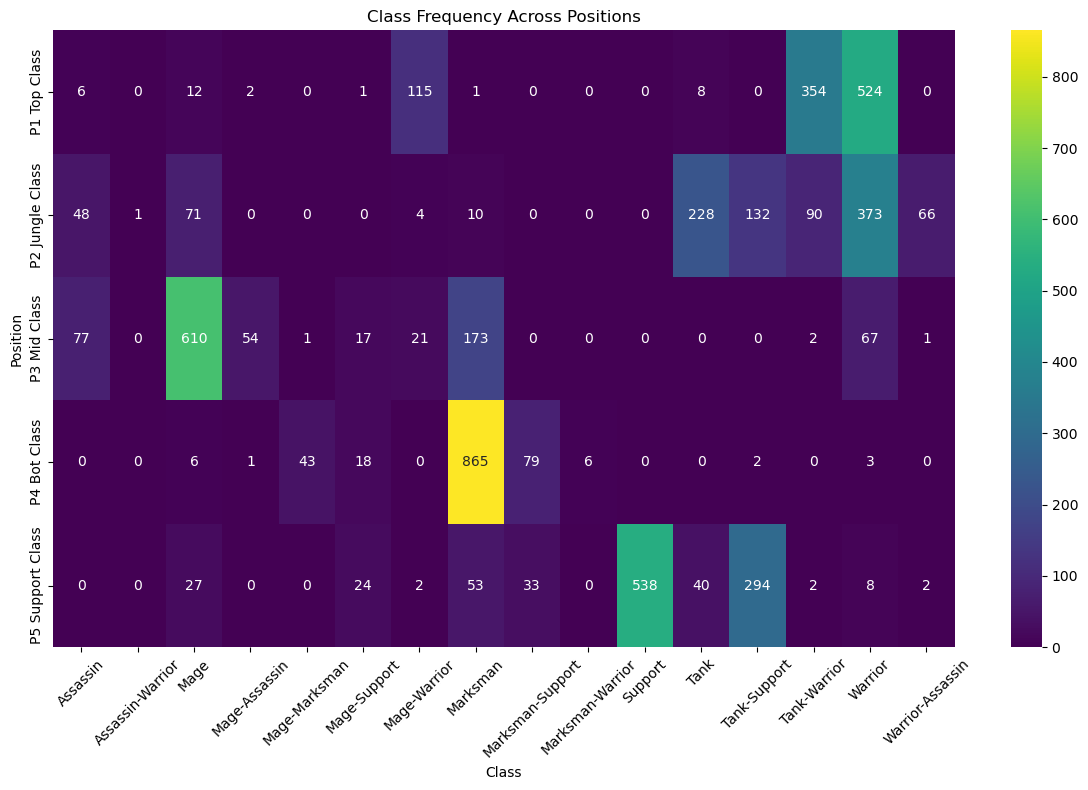

In [9]:
# Pivot the DataFrame
heatmap_data = class_frequencies_melted.pivot_table(index='index', columns='Class', values='Frequency', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.0f')  # Use '.0f' for floats
plt.title('Class Frequency Across Positions')
plt.xlabel('Class')
plt.ylabel('Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

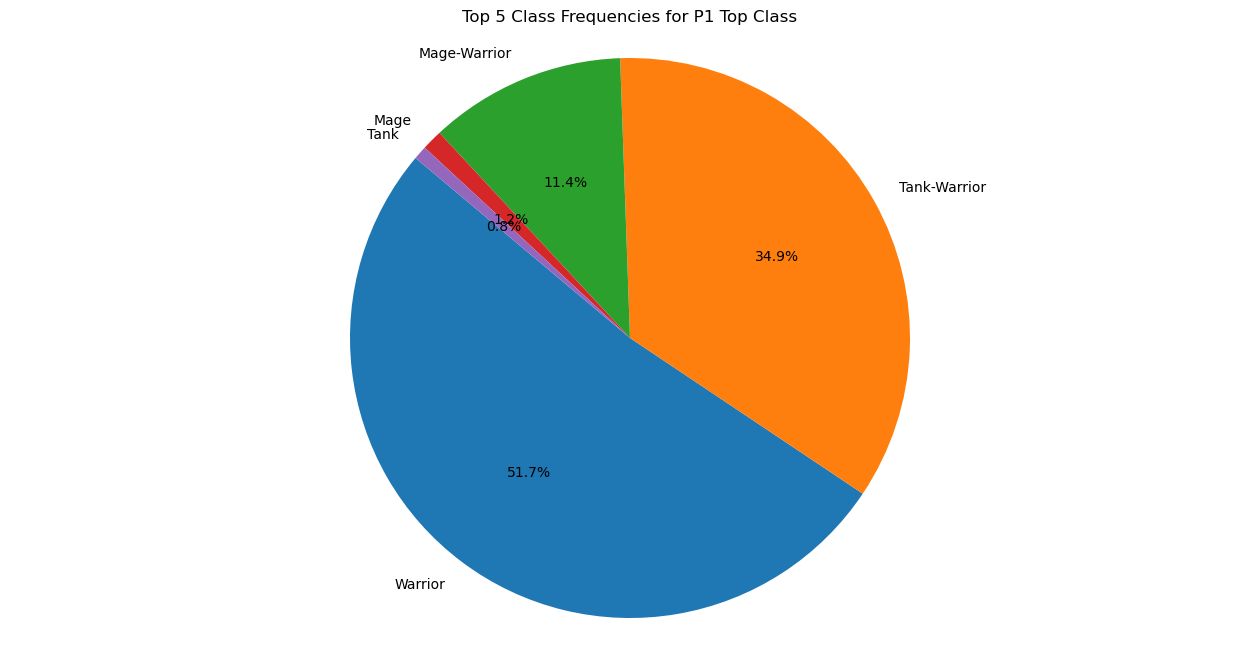

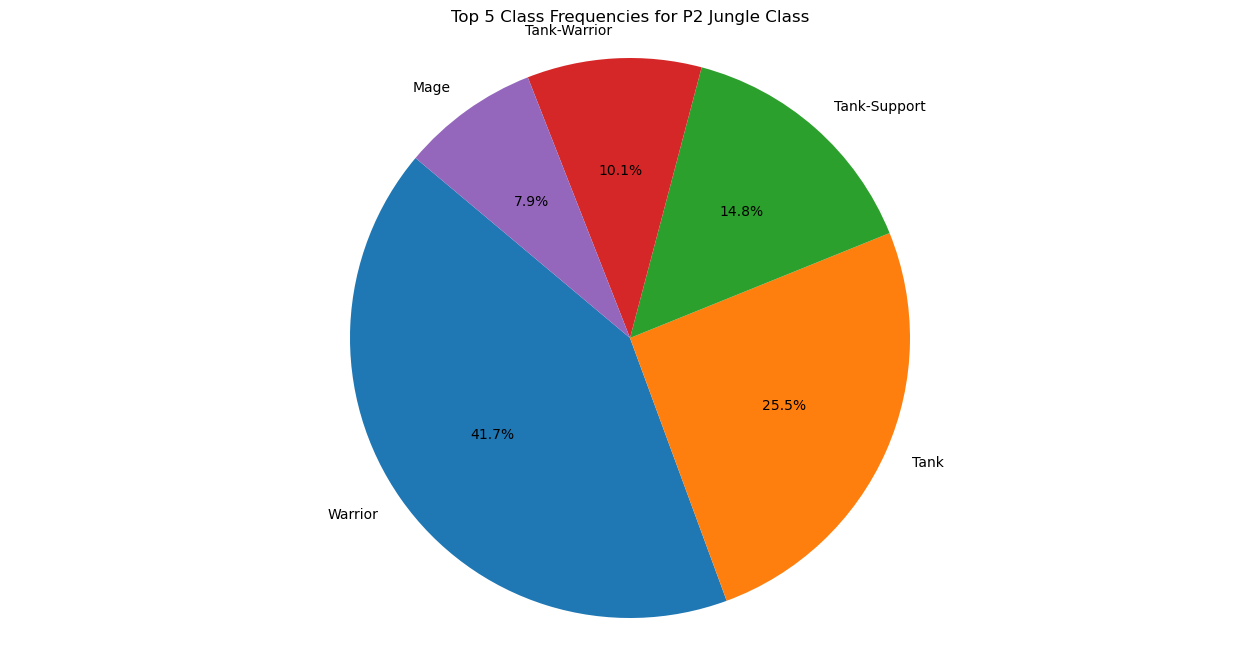

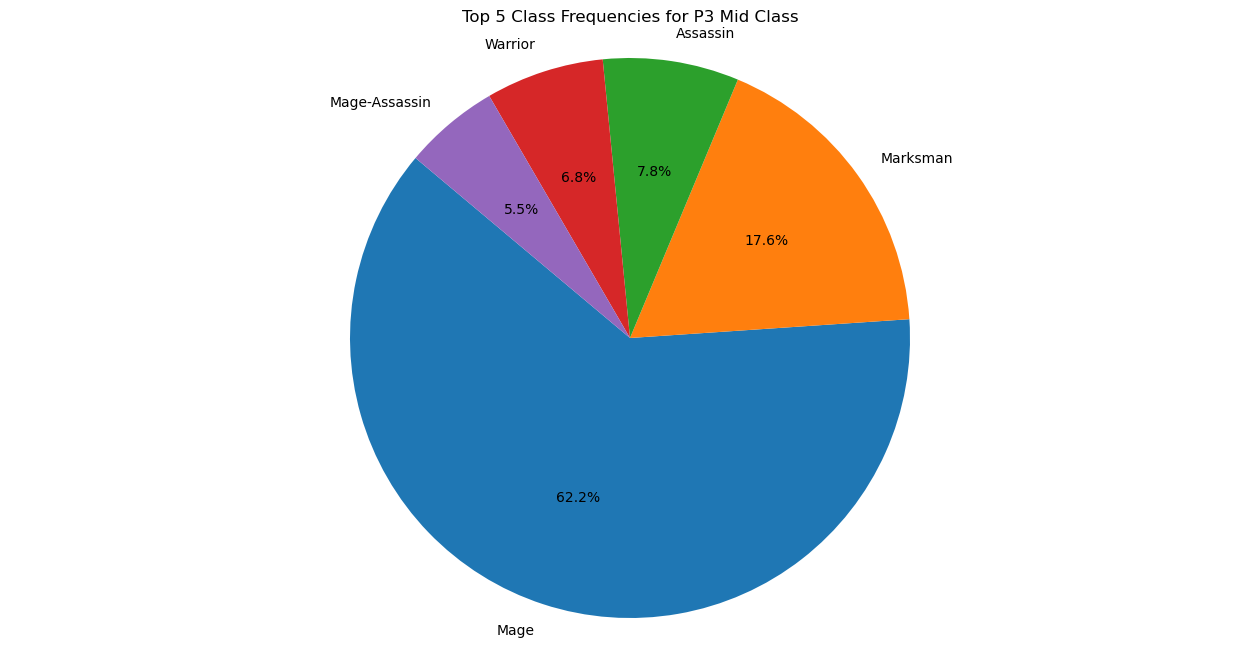

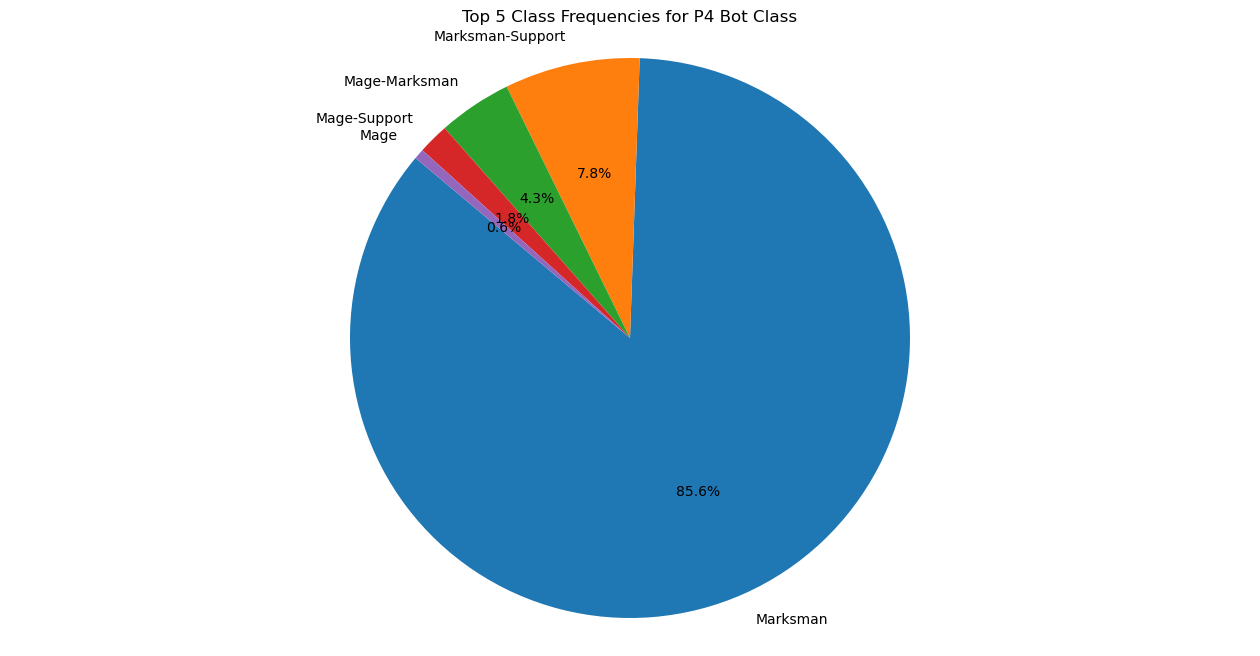

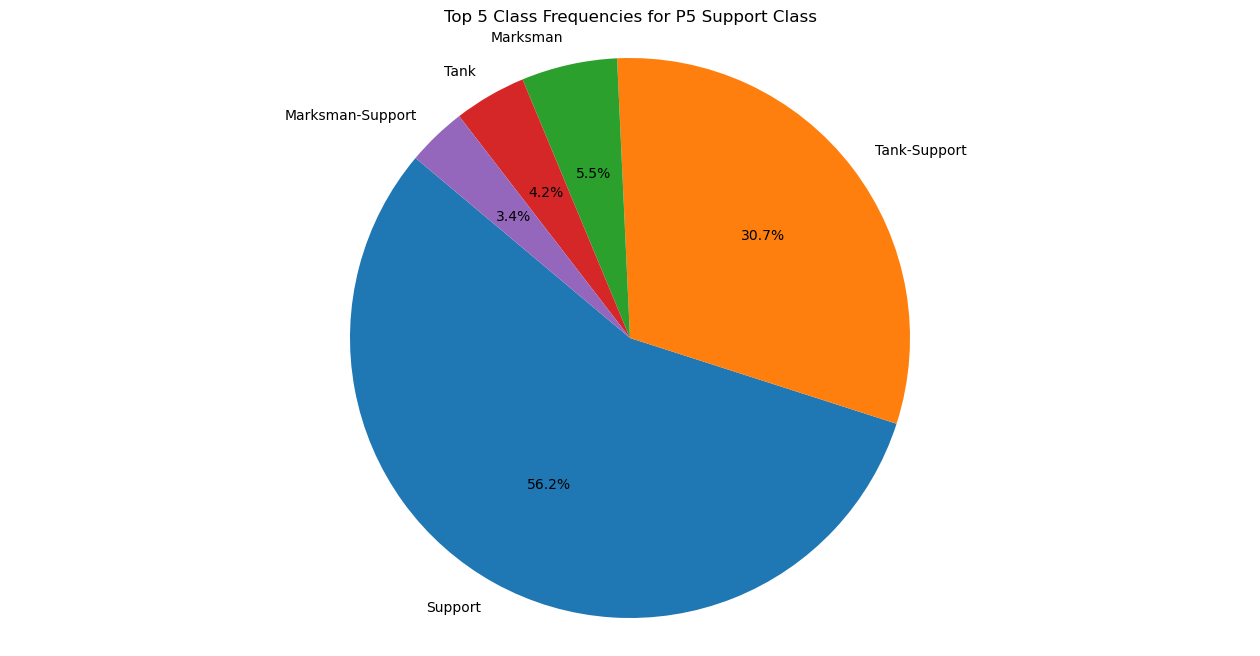

In [10]:
# Iterate over each position
positions = class_frequencies_melted['index'].unique()
for position in positions:
    # Filter data for the current position
    df_position = class_frequencies_melted[class_frequencies_melted['index'] == position]
    
    # Calculate total frequencies for each class for the current position
    total_class_frequencies = df_position.groupby('Class')['Frequency'].sum()
    
    # Sort the class frequencies in descending order and select the top 5 classes
    top_5_classes = total_class_frequencies.sort_values(ascending=False).head(5)
    
    # Plot the pie chart for the top 5 classes in the current position
    plt.figure(figsize=(16, 8))
    plt.pie(top_5_classes, labels=top_5_classes.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Top 5 Class Frequencies for {position}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()


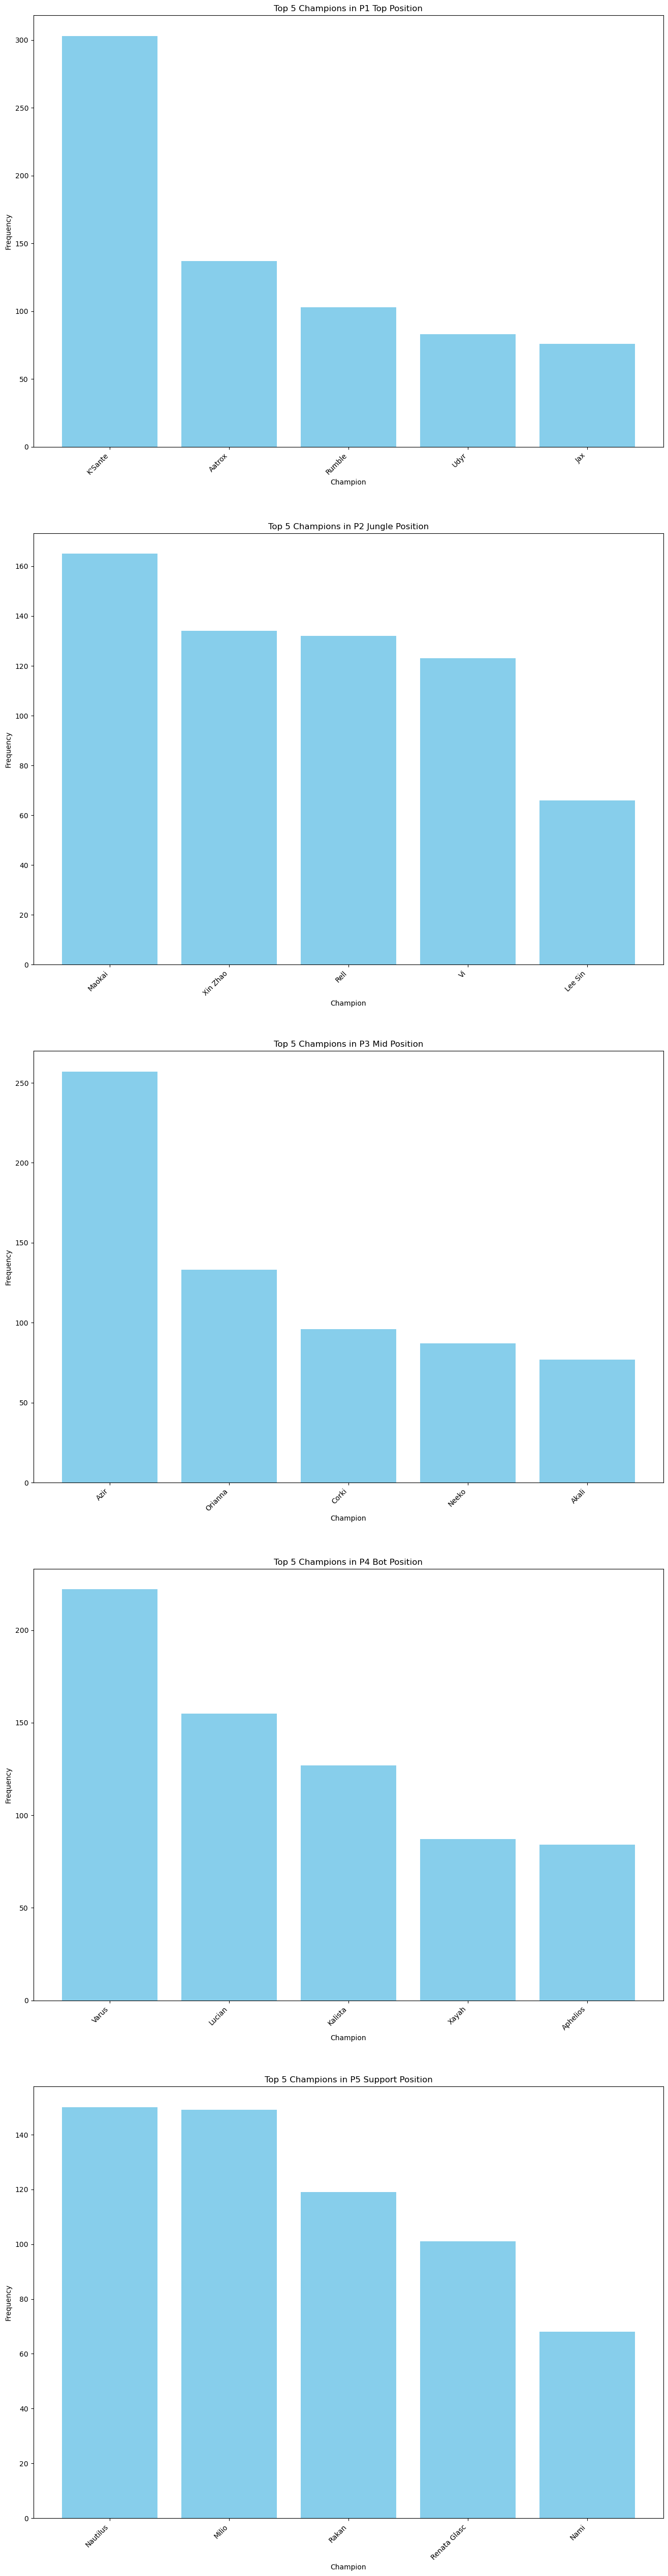

In [11]:
# Assuming 'combined_dataframe' is the name of your DataFrame
# Assuming you have already combined your dataframes and stored them in 'combined_dataframe'

# Define positions
positions = ['P1 Top', 'P2 Jungle', 'P3 Mid', 'P4 Bot', 'P5 Support']

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(16, 64))

# Loop through positions and plot
for i, pos in enumerate(positions):
    # Count the occurrences of each champion in the current position
    top_10_champions = combined_dataframe[pos].value_counts().head(5)
    
    # Plotting
    axs[i].bar(top_10_champions.index, top_10_champions.values, color='skyblue')
    axs[i].set_title(f'Top 5 Champions in {pos} Position')
    axs[i].set_xlabel('Champion')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)

    axs[i].set_xticks(range(len(top_10_champions.index)))
    axs[i].set_xticklabels(top_10_champions.index, rotation=45, ha='right')

# Adjust layout
plt.show()

---

### Win Rate Predictor Based on Champion Class and Position

In [12]:

# 2024_LoL_esports_match_data_from_OraclesElixir_gamedata_v4.csv
all_data = pd.read_csv('datasets/2024_LoL_esports_match_data_from_OraclesElixir_gamedata.csv', sep=',')
all_data.head()

clean_data = pd.DataFrame(all_data[['t1_result', 't2_result', 't1p1_champion', 't1p2_champion', 't1p3_champion', 't1p4_champion', 't1p5_champion', 't2p1_champion', 't2p2_champion', 't2p3_champion', 't2p4_champion', 't2p5_champion']])
clean_data.head()

# Response
team1 = pd.DataFrame(clean_data[['t1_result', 't1p1_champion', 't1p2_champion', 't1p3_champion', 't1p4_champion', 't1p5_champion']])
# Predictor
team2 = pd.DataFrame(clean_data[['t2_result', 't2p1_champion', 't2p2_champion', 't2p3_champion', 't2p4_champion', 't2p5_champion']])

team1.columns = ['result', 'p1', 'p2', 'p3', 'p4', 'p5']
team2.columns = ['result', 'p1', 'p2', 'p3', 'p4', 'p5']

all_team = pd.concat([team1, team2], ignore_index=True)
display(all_team)

# ------------------------------------------------------------------------------

# LOL-Champions.csv
champion_data = pd.read_csv('datasets/LoL-Champions.csv')
clean_champion_data = pd.DataFrame(champion_data[['Name', 'Class']])

# ------------------------------------------------------------------------------

# Merging both data sets
merged_data = pd.merge(all_team, clean_champion_data, left_on='p1', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'p1_class'}, inplace=True)
merged_data.drop('Name', axis=1, inplace=True)

merged_data = pd.merge(merged_data, clean_champion_data, left_on='p2', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'p2_class'}, inplace=True)
merged_data.drop('Name', axis=1, inplace=True)

merged_data = pd.merge(merged_data, clean_champion_data, left_on='p3', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'p3_class'}, inplace=True)
merged_data.drop('Name', axis=1, inplace=True)

merged_data = pd.merge(merged_data, clean_champion_data, left_on='p4', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'p4_class'}, inplace=True)
merged_data.drop('Name', axis=1, inplace=True)

merged_data = pd.merge(merged_data, clean_champion_data, left_on='p5', right_on='Name', how='left')
merged_data.rename(columns={'Class': 'p5_class'}, inplace=True)
merged_data.drop('Name', axis=1, inplace=True)

columns_order = ['result', 'p1', 'p1_class', 'p2', 'p2_class', 'p3', 'p3_class', 'p4', 'p4_class', 'p5', 'p5_class']
final_clean_team_data = merged_data[columns_order]

display(merged_data)

# ------------------------------------------------------------------------------

# Prediction

# y = pd.DataFrame(final_clean_team_data[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'p5_class']])
# X = pd.DataFrame(final_clean_team_data[['result', 'p1_class', 'p2_class', 'p3_class', 'p4_class', 'p5_class']])

X = pd.DataFrame(final_clean_team_data[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'p5_class']])
y = pd.DataFrame(final_clean_team_data[['result']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)



,result,p1,p2,p3,p4,p5
0,1,Jax,Bel'Veth,Neeko,Caitlyn,Lux
1,1,Udyr,Xin Zhao,Azir,Kalista,Renata Glasc
2,1,Zac,Vi,Azir,Senna,Maokai
3,1,Aatrox,Jax,Hwei,Kalista,Nautilus
4,1,Rumble,Maokai,Tristana,Lucian,Milio
...,...,...,...,...,...,...
2041,1,Gnar,Rell,Kai'Sa,Varus,Renata Glasc
2042,1,K'Sante,Maokai,LeBlanc,Kalista,Zyra
2043,1,K'Sante,Lee Sin,Azir,Senna,Nautilus
2044,1,K'Sante,Jax,Orianna,Kalista,Rell


,result,p1,p2,p3,p4,p5,p1_class,p2_class,p3_class,p4_class,p5_class
0,1,Jax,Bel'Veth,Neeko,Caitlyn,Lux,Warrior,Warrior,Mage,Marksman,Mage
1,1,Udyr,Xin Zhao,Azir,Kalista,Renata Glasc,Warrior,Warrior,Mage,Marksman,Support
2,1,Zac,Vi,Azir,Senna,Maokai,Tank-Warrior,Warrior,Mage,Marksman-Support,Tank
3,1,Aatrox,Jax,Hwei,Kalista,Nautilus,Warrior,Warrior,Mage,Marksman,Tank-Support
4,1,Rumble,Maokai,Tristana,Lucian,Milio,Mage-Warrior,Tank,Marksman,Marksman,Support
...,...,...,...,...,...,...,...,...,...,...,...
2041,1,Gnar,Rell,Kai'Sa,Varus,Renata Glasc,Warrior,Tank-Support,Marksman,Marksman,Support
2042,1,K'Sante,Maokai,LeBlanc,Kalista,Zyra,Tank-Warrior,Tank,Mage-Assassin,Marksman,Mage-Support
2043,1,K'Sante,Lee Sin,Azir,Senna,Nautilus,Tank-Warrior,Warrior-Assassin,Mage,Marksman-Support,Tank-Support
2044,1,K'Sante,Jax,Orianna,Kalista,Rell,Tank-Warrior,Warrior,Mage,Marksman,Tank-Support


In [13]:
X_train.describe()
y_train.describe()

,result
count,1534.000000
mean,0.495437
std,0.500142
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [14]:
# method 1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

categorical_columns = ['p1_class', 'p2_class', 'p3_class', 'p4_class', 'p5_class']

X = pd.DataFrame(final_clean_team_data[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'p5_class']])
y = pd.DataFrame(final_clean_team_data[['result']])

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Append regression model to preprocessing pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", model.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", model.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.05274810506413374
Mean Squared Error (MSE) 	: 0.23680731109508382

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.05805690232112748
Mean Squared Error (MSE) 	: 0.26441351820111986



In [15]:
# method 2

# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

data_encoded = pd.get_dummies(final_clean_team_data)

X = data_encoded.drop('result', axis=1)
y = data_encoded['result']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", model.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", model.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.08213764018430114
Mean Squared Error (MSE) 	: 0.22946010300466077

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -2.0461489805952876e+25
Mean Squared Error (MSE) 	: 5.113424897431733e+24



Both version of linear regresion has negative Explained Variance. This could mean the following:
- Team composition & result (win/loss) is not linear
- Data is overfitted
- Inadequate Features
- Data Leakage

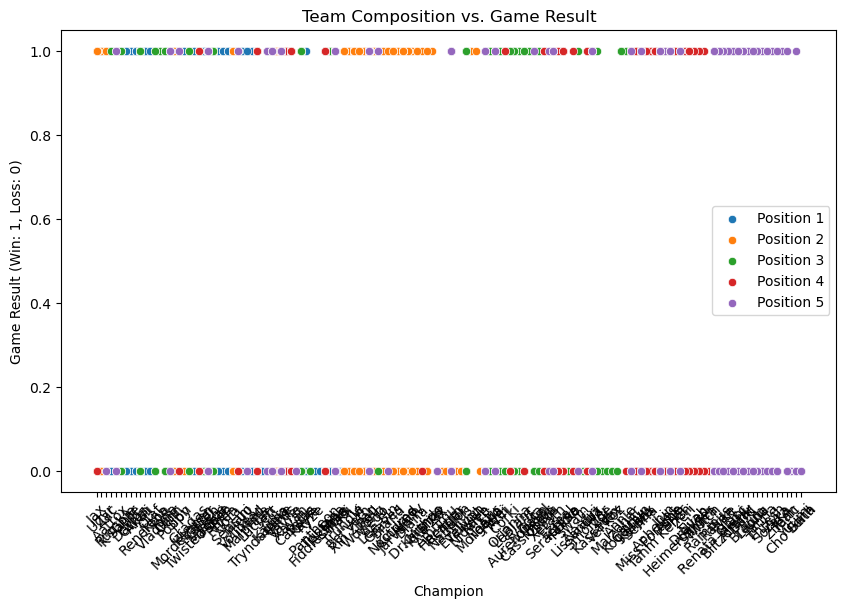

In [16]:
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='p1', y='result', data=merged_data, label='Position 1')
sns.scatterplot(x='p2', y='result', data=merged_data, label='Position 2')
sns.scatterplot(x='p3', y='result', data=merged_data, label='Position 3')
sns.scatterplot(x='p4', y='result', data=merged_data, label='Position 4')
sns.scatterplot(x='p5', y='result', data=merged_data, label='Position 5')

plt.title('Team Composition vs. Game Result')
plt.xlabel('Champion')
plt.ylabel('Game Result (Win: 1, Loss: 0)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

From the above diagram, we learn that Team composition & result (win/loss) is not linear.

After doing some research, we could use Random Trees predicting Binary values.

We will show that next.

In [17]:
# One-hot encode champion columns
champion_columns = ['t1p1_champion', 't1p2_champion', 't1p3_champion', 't1p4_champion', 't1p5_champion',
                    't2p1_champion', 't2p2_champion', 't2p3_champion', 't2p4_champion', 't2p5_champion','t1p1_class', 't1p2_class', 't1p3_class', 't1p4_class', 't1p5_class',
                    't2p1_class', 't2p2_class', 't2p3_class', 't2p4_class', 't2p5_class']


merged_data_loldataQtn2_columnsUpdated = pd.read_csv('datasets/cleaned_dataset_matchWinner.csv', sep=',')


merged_data_loldataQtn2_columnsUpdated = pd.get_dummies(merged_data_loldataQtn2_columnsUpdated, columns=champion_columns)

# Convert matchWinner values to numeric
# merged_data_loldataQtn2_columnsUpdated['matchWinner'] = merged_data_loldataQtn2_columnsUpdated['matchWinner'].astype(int)

# Split the data into features (X) and target (y)
X = merged_data_loldataQtn2_columnsUpdated.drop('matchWinner', axis=1)
y = merged_data_loldataQtn2_columnsUpdated['matchWinner']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=1)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9609756097560975


In [18]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002765357A690>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027653391250>})

In [19]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 8, 'n_estimators': 425}


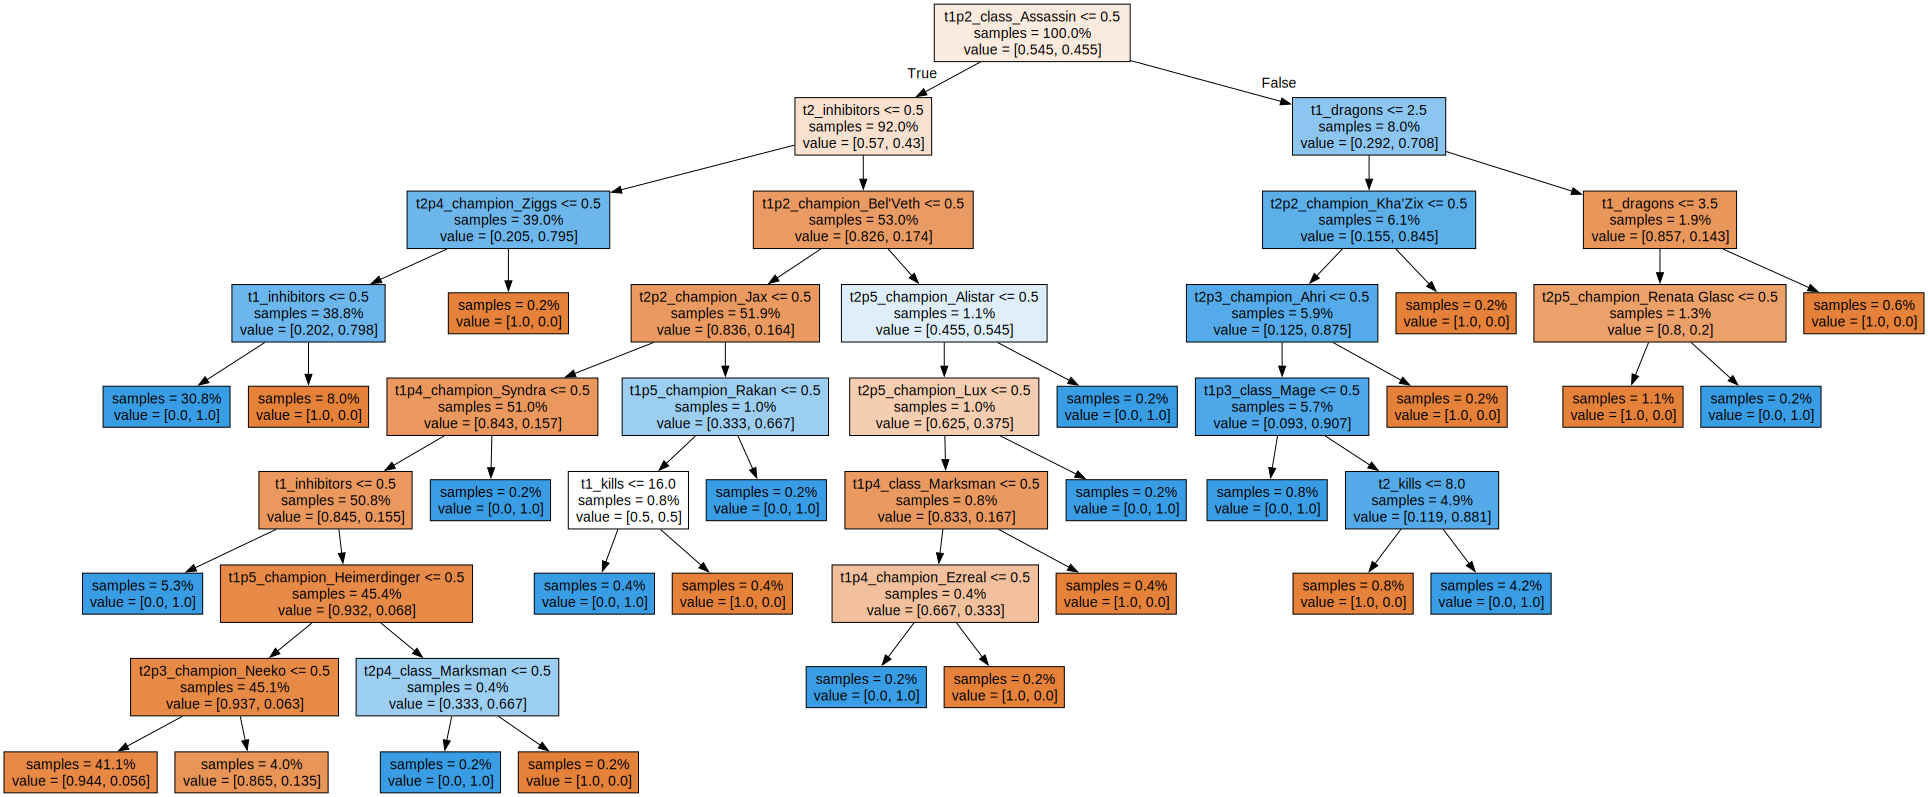

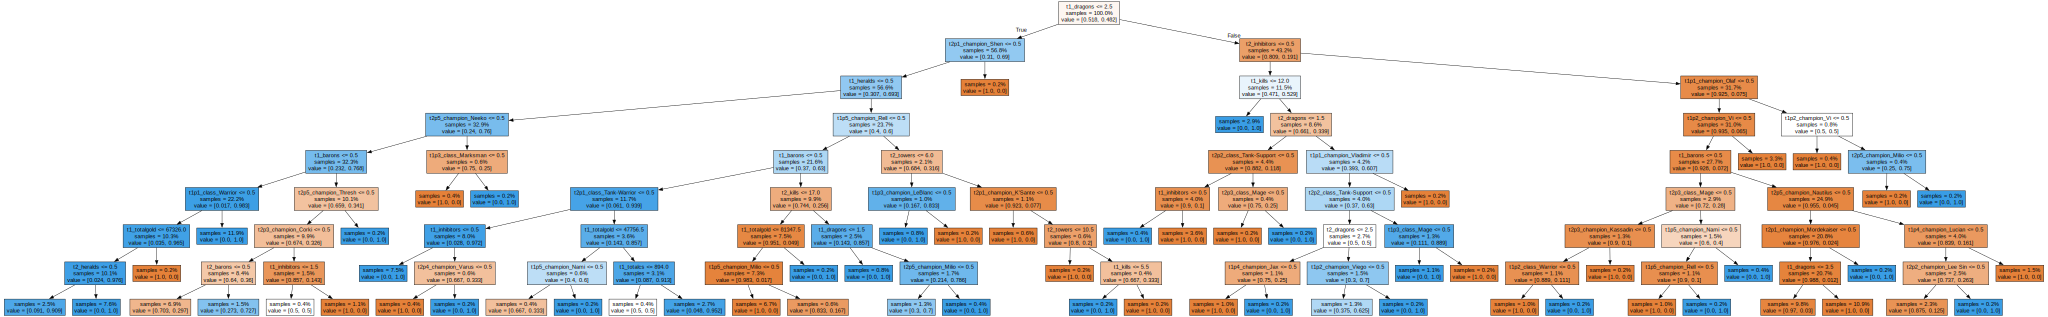

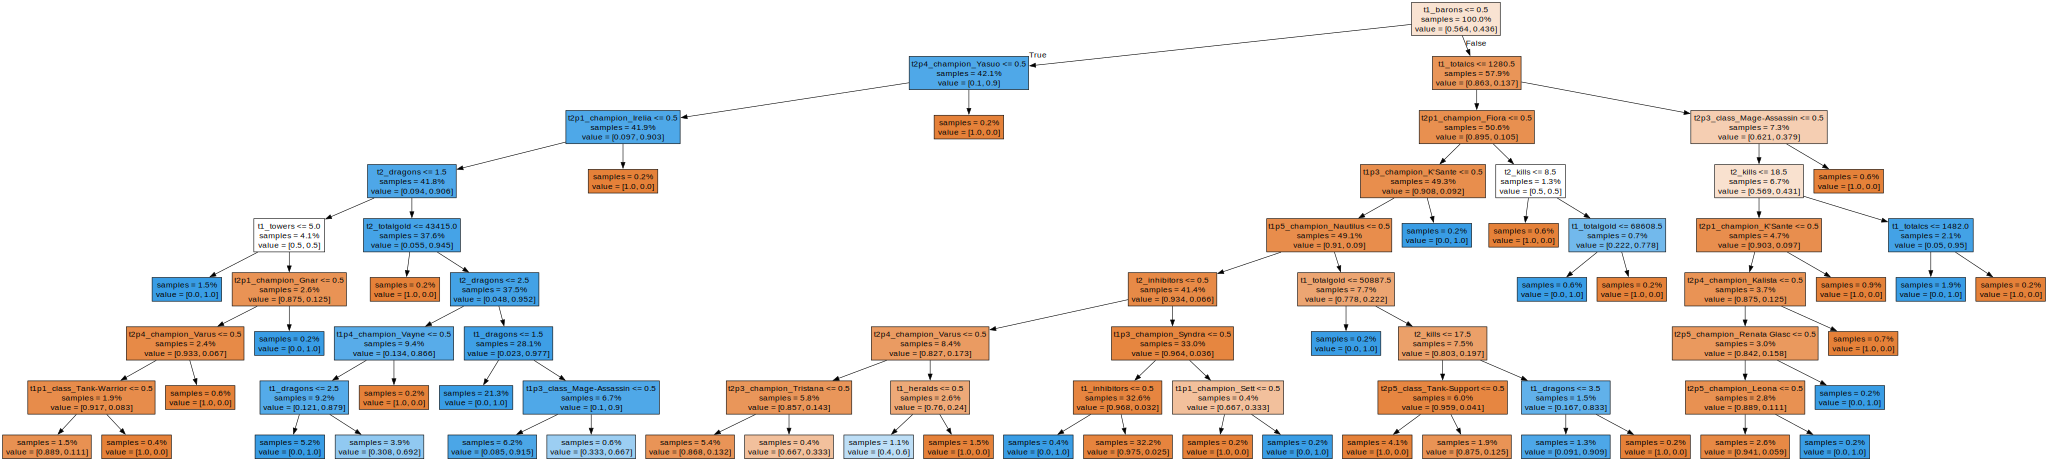

In [20]:
# Export the first three decision trees from the forest

# Get the best hyperparameters from the best model
best_hyperparameters = best_rf.get_params()

# Retrieve the value of max_depth
max_depth = best_hyperparameters['max_depth']


for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=max_depth, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


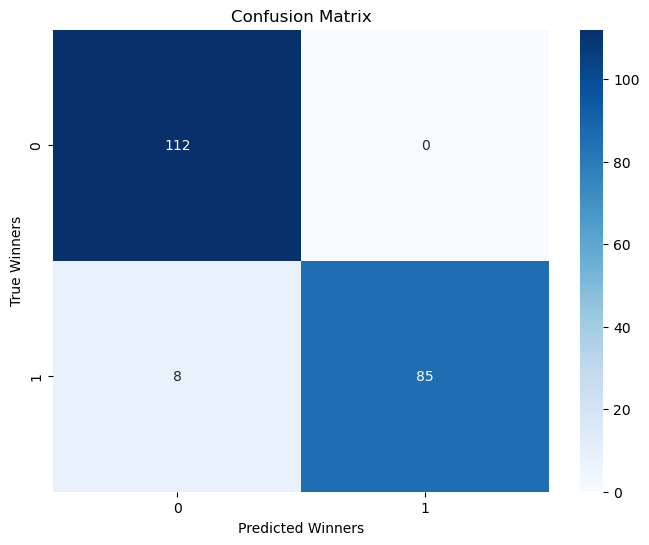

In [21]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using matplotlib and seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Winners')
plt.ylabel('True Winners')
plt.title('Confusion Matrix')
plt.show()

In [22]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9609756097560975
Precision: 0.9333333333333333
Recall: 1.0


---

## Which factors contributes to the most amount of gold earned (minion, kills, towers, neutral objectives (Baron, Dragon, Jungle camps))?

Baron, Dragon, Herald, Tower,

In [23]:
loldataQtn2_columnsUpdated = pd.read_csv('datasets/cleaned_dataset_gold.csv', sep=',')

# Combine T1 and T2 values for each column
for column in loldataQtn2_columnsUpdated.columns:
    if column.startswith('t1'):
        corresponding_column = 't2' + column[2:]
        if corresponding_column in loldataQtn2_columnsUpdated.columns:
            loldataQtn2_columnsUpdated[column] += loldataQtn2_columnsUpdated[corresponding_column]

# Drop T2 columns
loldataQtn2_columnsUpdateddf = loldataQtn2_columnsUpdated[[col for col in loldataQtn2_columnsUpdated.columns if not col.startswith('t2')]]
# Rename columns by removing 'T1' prefix
loldataQtn2_columnsUpdateddf.columns = [col.replace('t1_', '') for col in loldataQtn2_columnsUpdateddf.columns]

# Combine Barons, Dragons, and Heralds into Neutral Objectives
loldataQtn2_columnsUpdateddf_copy = loldataQtn2_columnsUpdateddf.copy()
loldataQtn2_columnsUpdateddf_copy['neutralObjectives'] = loldataQtn2_columnsUpdateddf['barons'] + loldataQtn2_columnsUpdateddf['dragons'] + loldataQtn2_columnsUpdateddf['heralds']
loldataQtn2_columnsUpdateddf_copy['structures'] = loldataQtn2_columnsUpdateddf['towers'] + loldataQtn2_columnsUpdateddf['inhibitors']

# Drop individual columns for Barons, Dragons, and Heralds
loldataQtn2_columnsUpdateddf_copy.drop(columns=['barons', 'dragons', 'heralds','towers','inhibitors'], inplace=True)

display(loldataQtn2_columnsUpdateddf_copy)


,totalgold,kills,totalcs,neutralObjectives,structures
0,81801,24,1374,4,12
1,81676,18,1472,5,20
2,82328,23,1492,4,24
3,84566,33,1305,4,24
4,80752,23,1484,4,22
...,...,...,...,...,...
1018,185513,48,3104,11,14
1019,185600,20,3444,9,18
1020,181016,47,2818,10,14
1021,187747,58,2928,10,20


In [24]:
totalGoldEarned = pd.DataFrame(loldataQtn2_columnsUpdateddf_copy['totalgold'])

structures = pd.DataFrame(loldataQtn2_columnsUpdateddf_copy['structures'])

neutral_Objectives = pd.DataFrame(loldataQtn2_columnsUpdateddf_copy['neutralObjectives'])

totalCS = pd.DataFrame(loldataQtn2_columnsUpdateddf_copy['totalcs'])

Kills = pd.DataFrame(loldataQtn2_columnsUpdateddf_copy['kills'])


<Axes: >

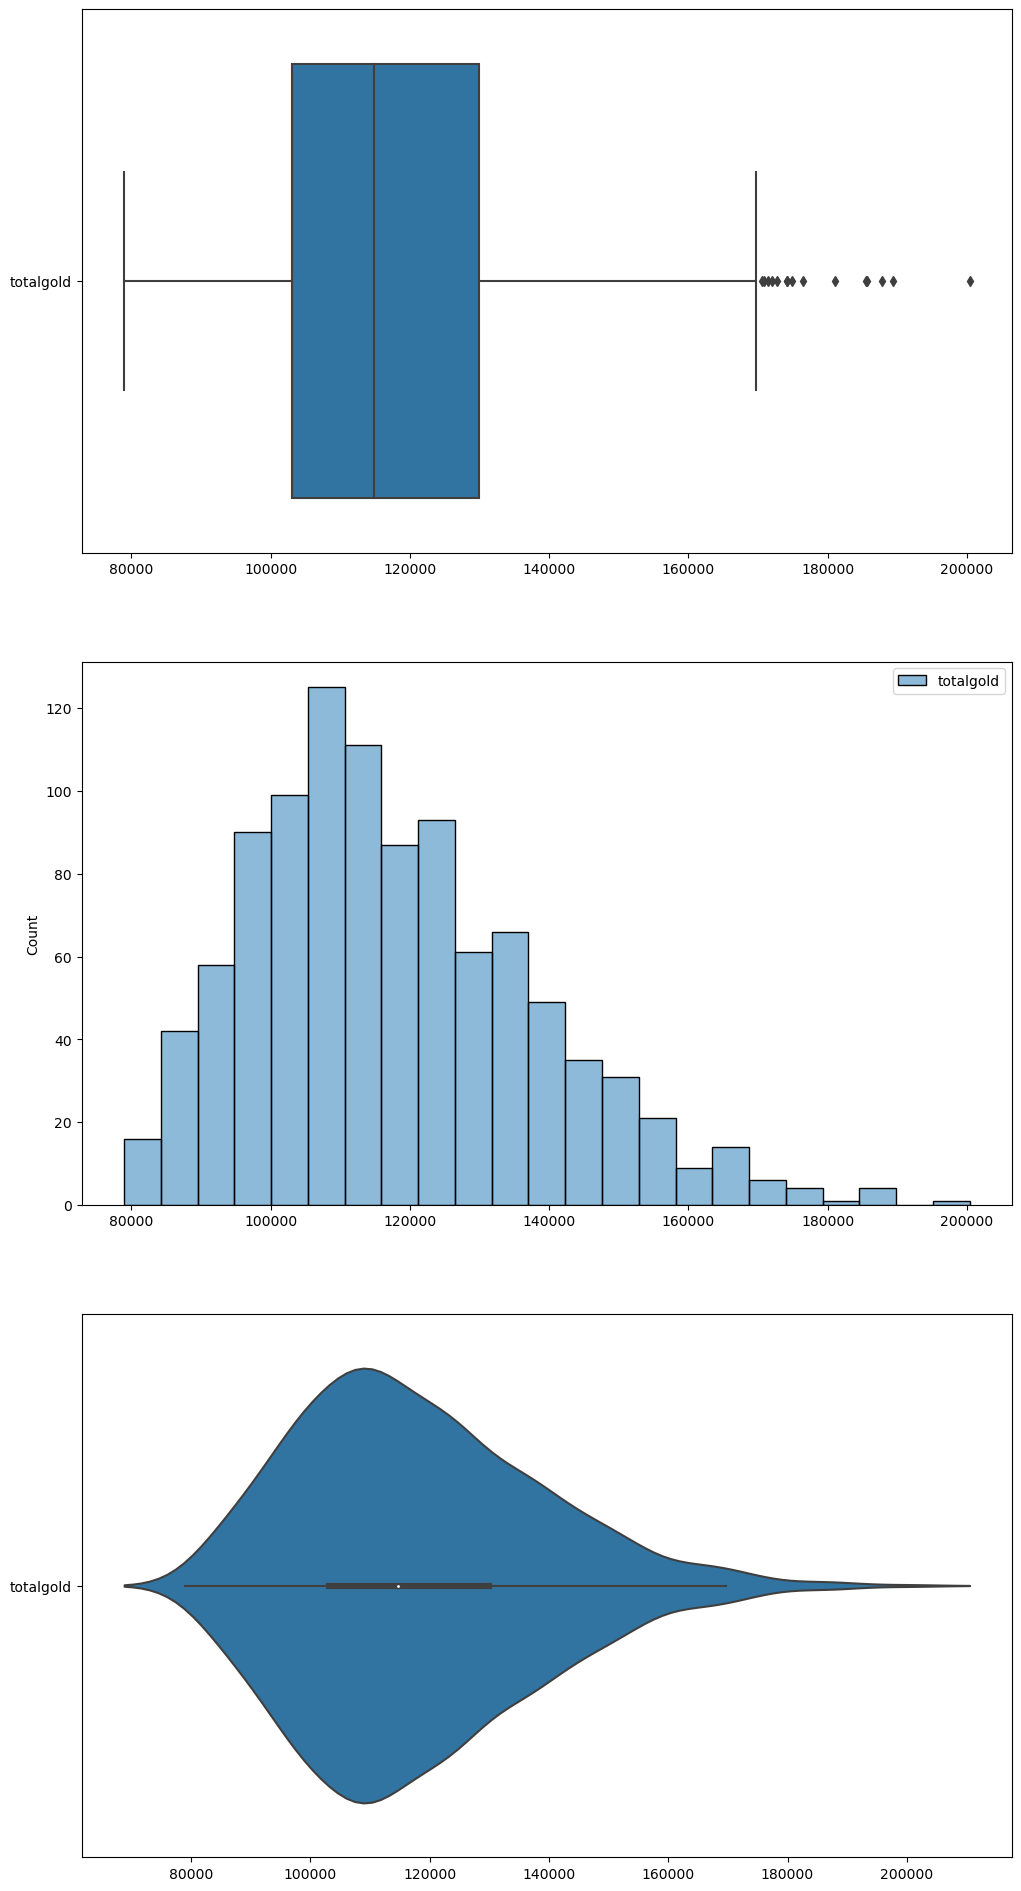

In [25]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(3, 1, figsize=(12, 24))

# Plot the basic uni-variate figures for HP Train
sns.boxplot(data = totalGoldEarned, orient = "h", ax = axes[0])
sns.histplot(data = totalGoldEarned, ax = axes[1])
sns.violinplot(data = totalGoldEarned, orient = "h", ax = axes[2])

<Axes: >

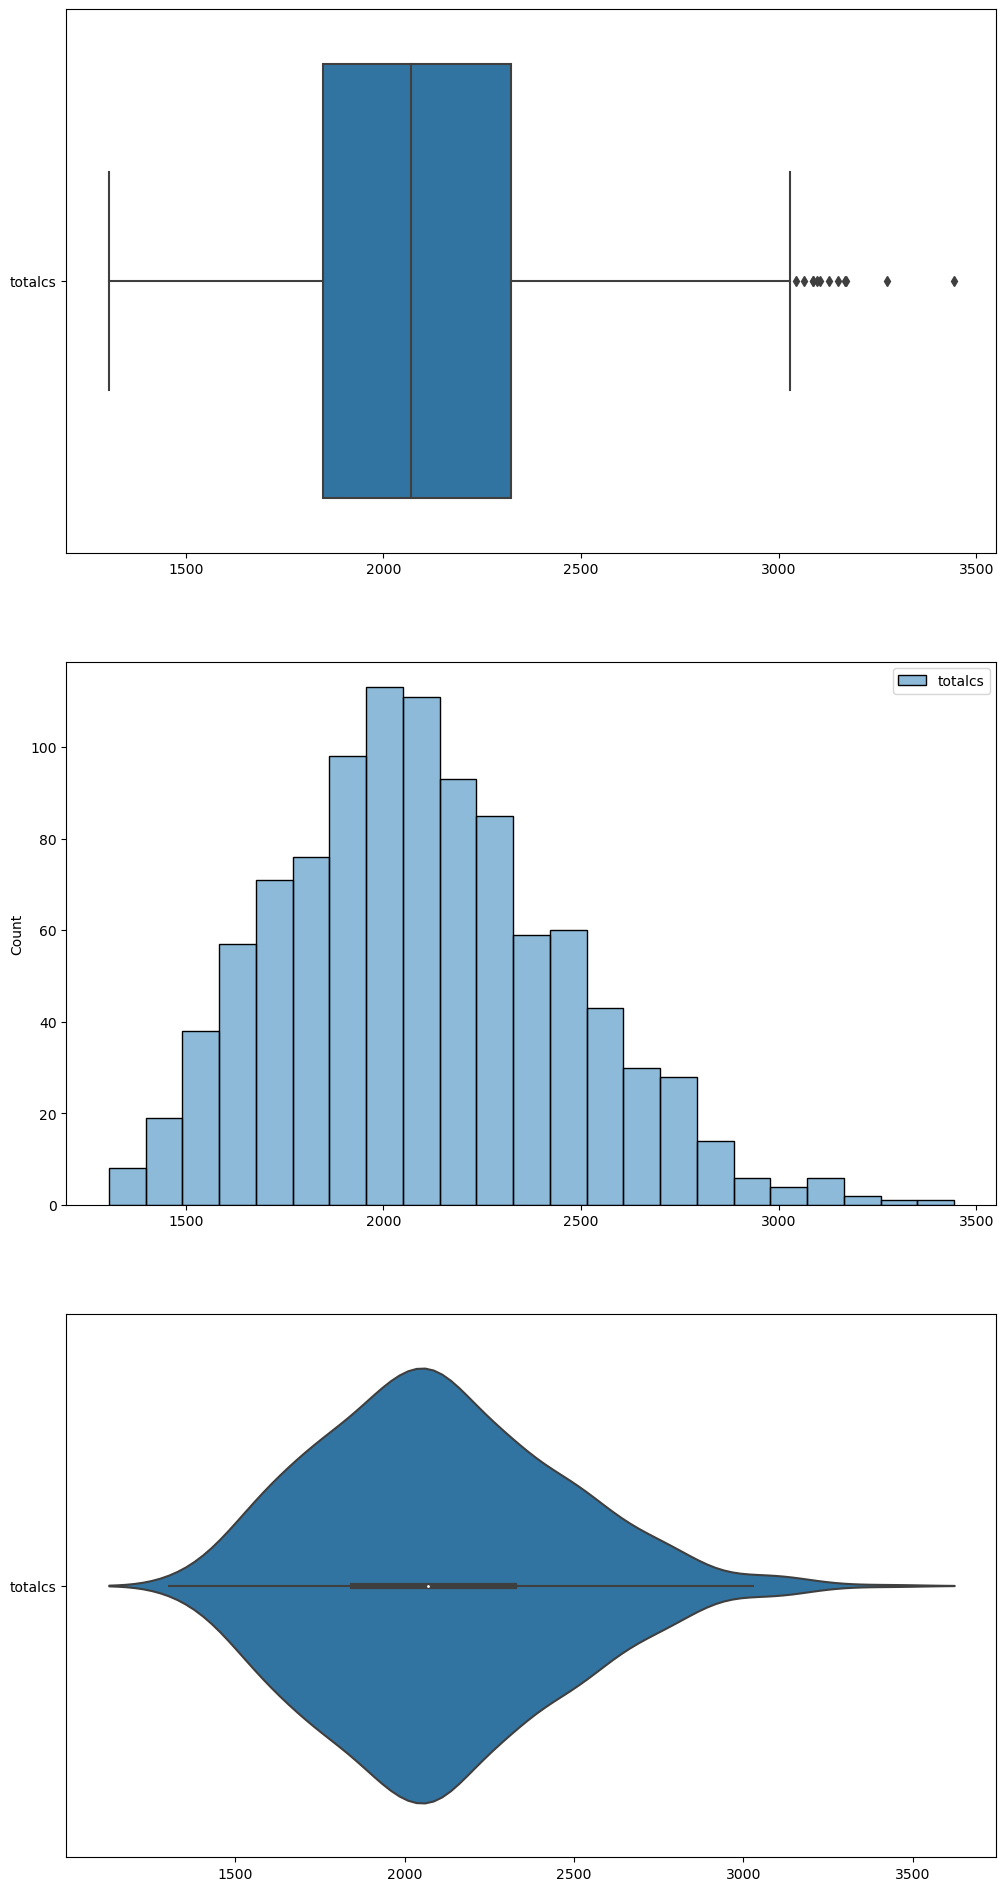

In [26]:
f, axes = plt.subplots(3, 1, figsize=(12, 24))

# Plot the basic uni-variate figures for HP Train
sns.boxplot(data = totalCS, orient = "h", ax = axes[0])
sns.histplot(data = totalCS, ax = axes[1])
sns.violinplot(data = totalCS, orient = "h", ax = axes[2])


<Axes: >

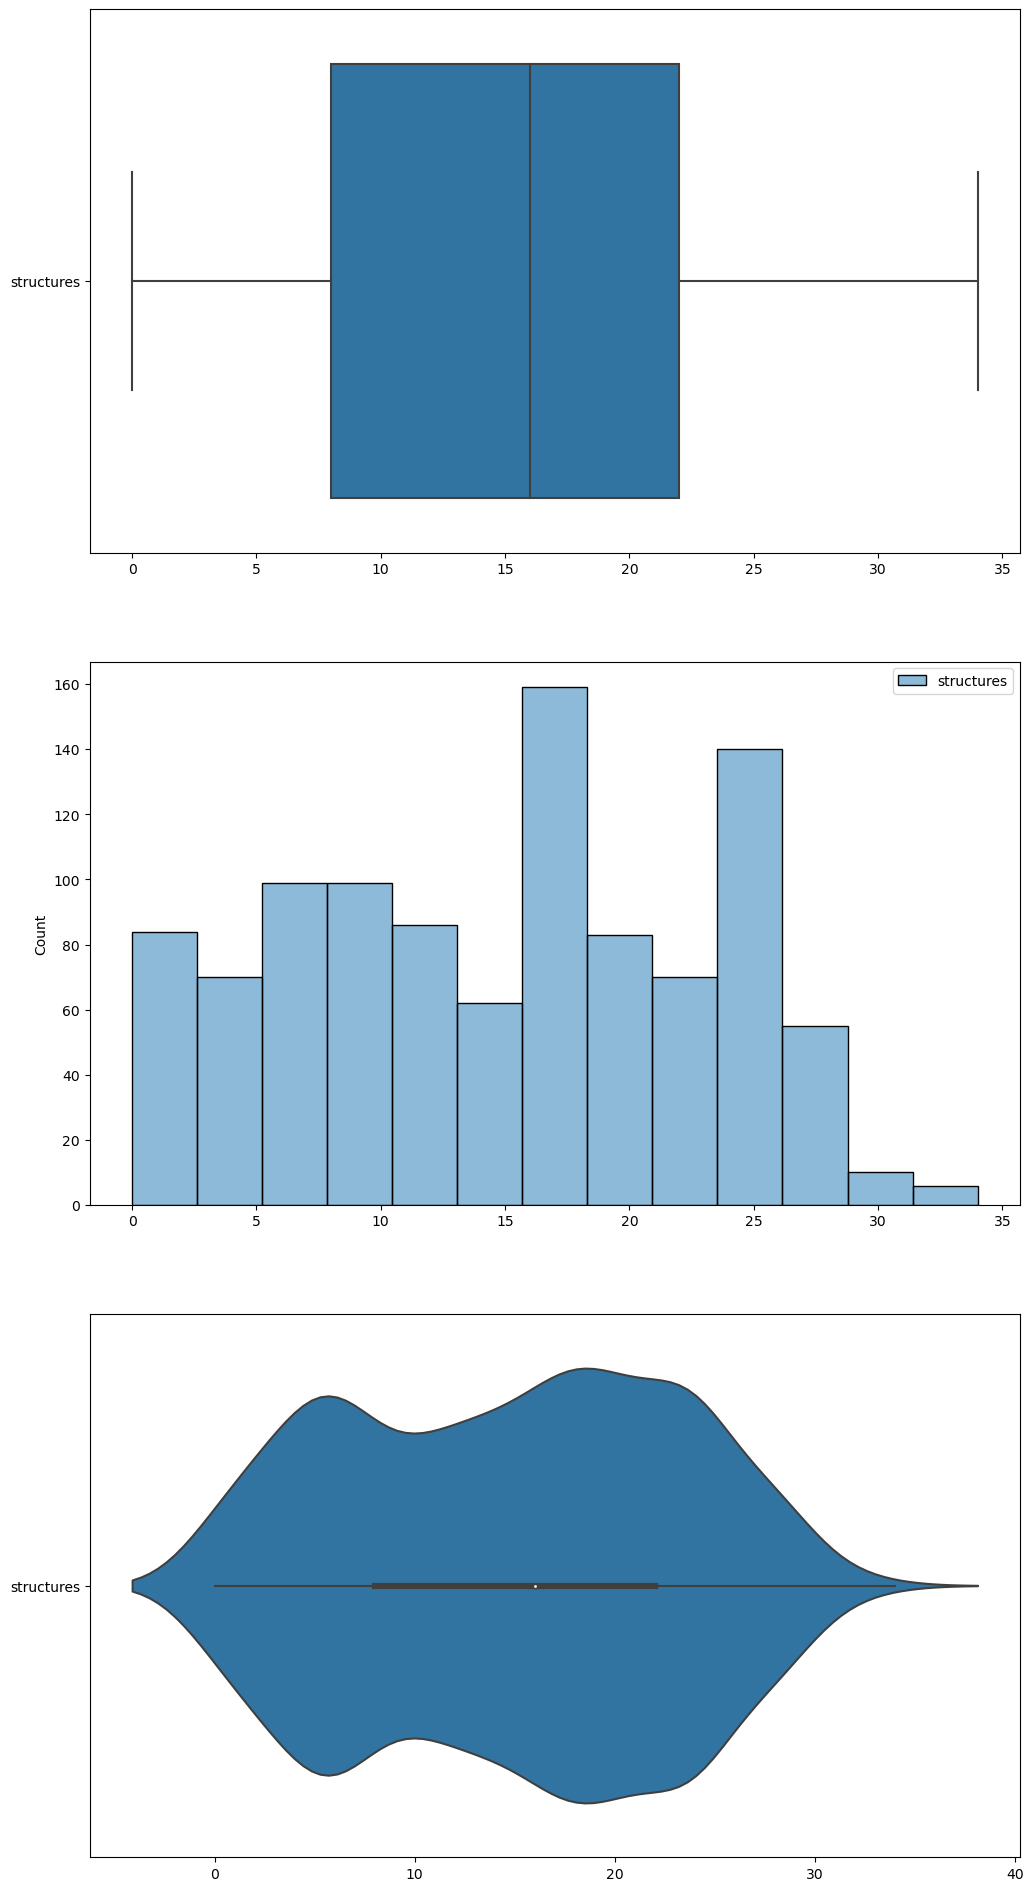

In [27]:
f, axes = plt.subplots(3, 1, figsize=(12, 24))

# Plot the basic uni-variate figures for HP Train
sns.boxplot(data = structures, orient = "h", ax = axes[0])
sns.histplot(data = structures, ax = axes[1])
sns.violinplot(data = structures, orient = "h", ax = axes[2])


<Axes: >

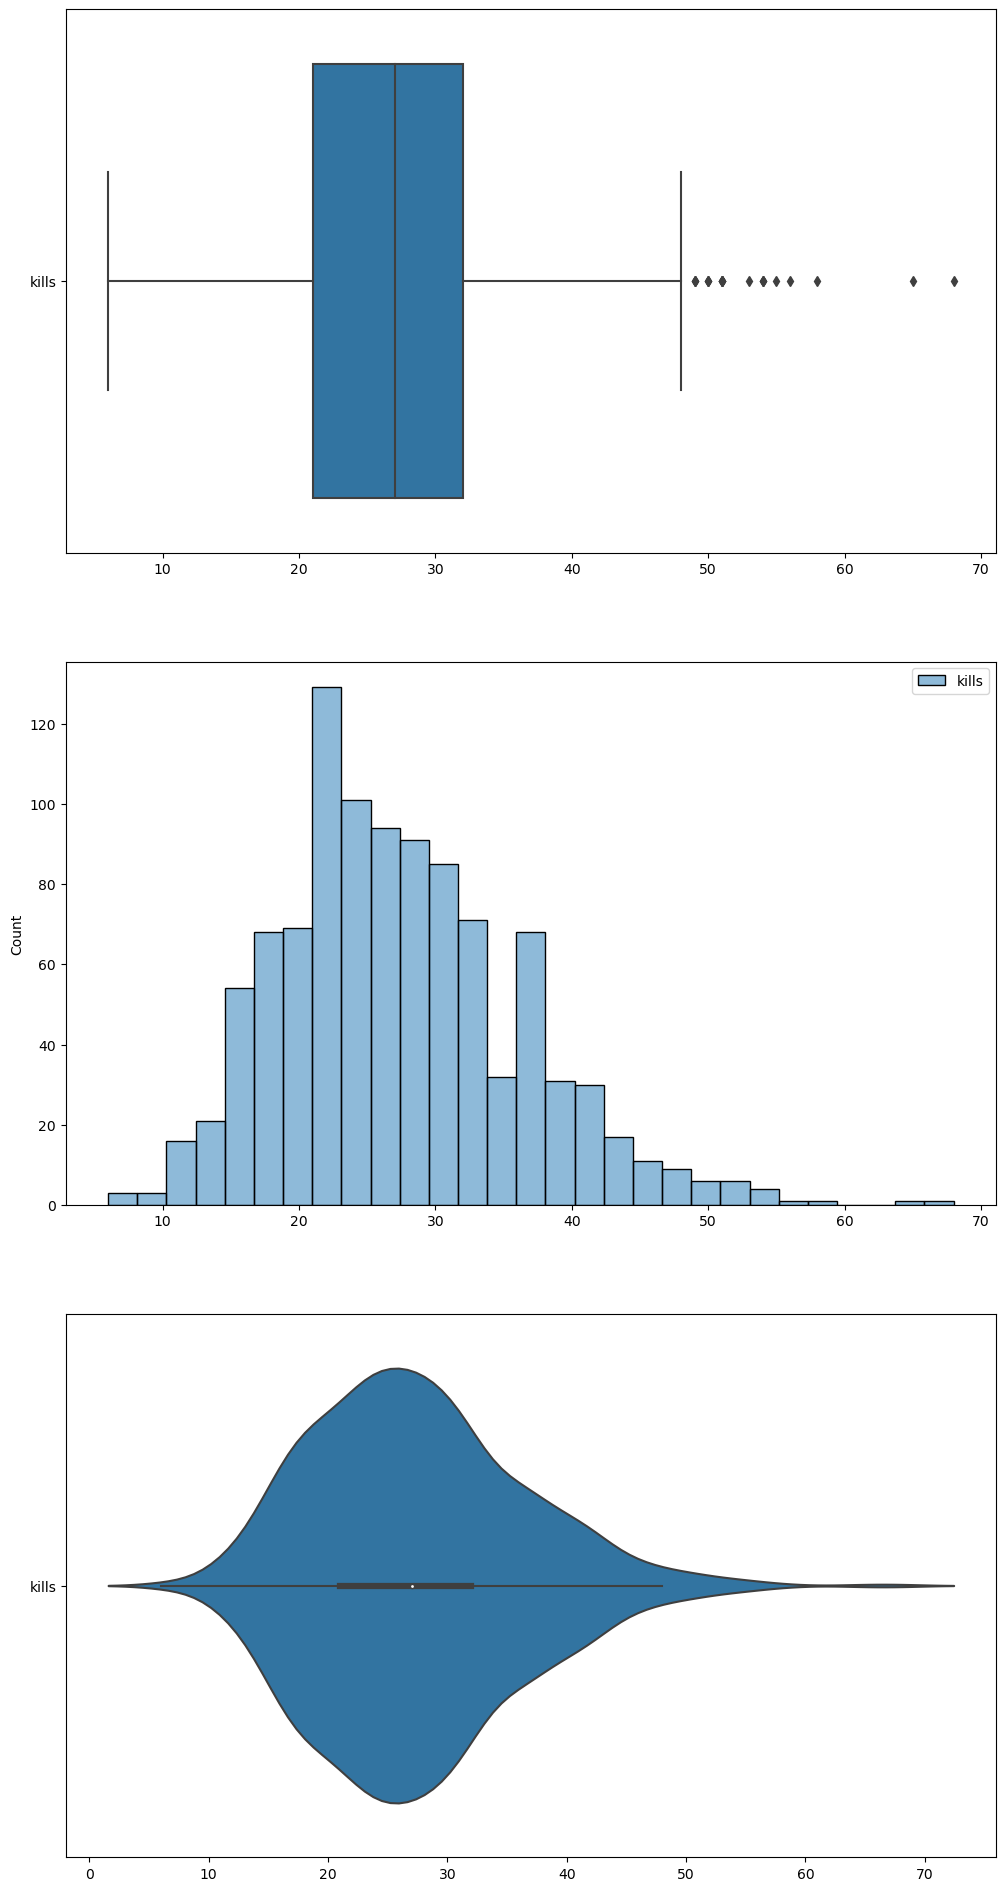

In [28]:
f, axes = plt.subplots(3, 1, figsize=(12, 24))

# Plot the basic uni-variate figures for HP Train
sns.boxplot(data = Kills, orient = "h", ax = axes[0])
sns.histplot(data = Kills, ax = axes[1])
sns.violinplot(data = Kills, orient = "h", ax = axes[2])


<Axes: >

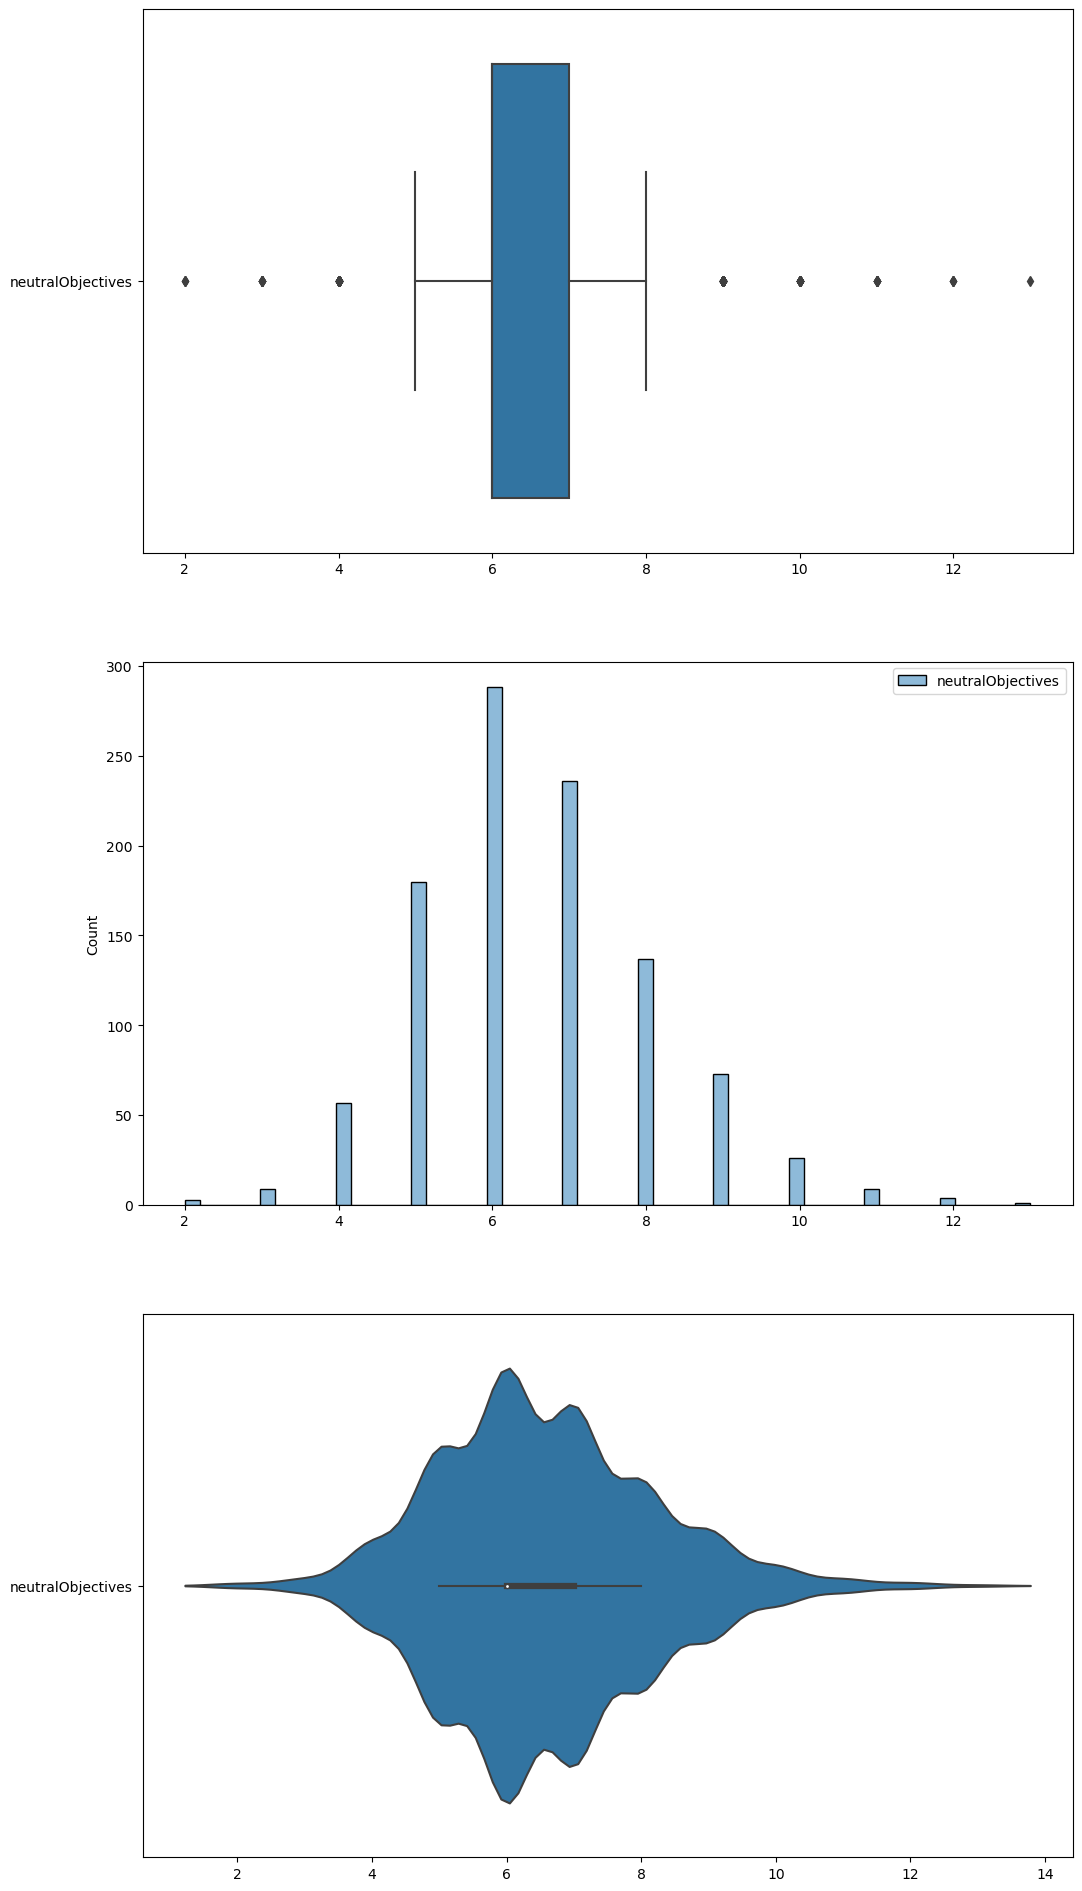

In [29]:
f, axes = plt.subplots(3, 1, figsize=(12, 24))

# Plot the basic uni-variate figures for Total Train
sns.boxplot(data = neutral_Objectives, orient = "h", ax = axes[0])
sns.histplot(data = neutral_Objectives, ax = axes[1])
sns.violinplot(data = neutral_Objectives, orient = "h", ax = axes[2])

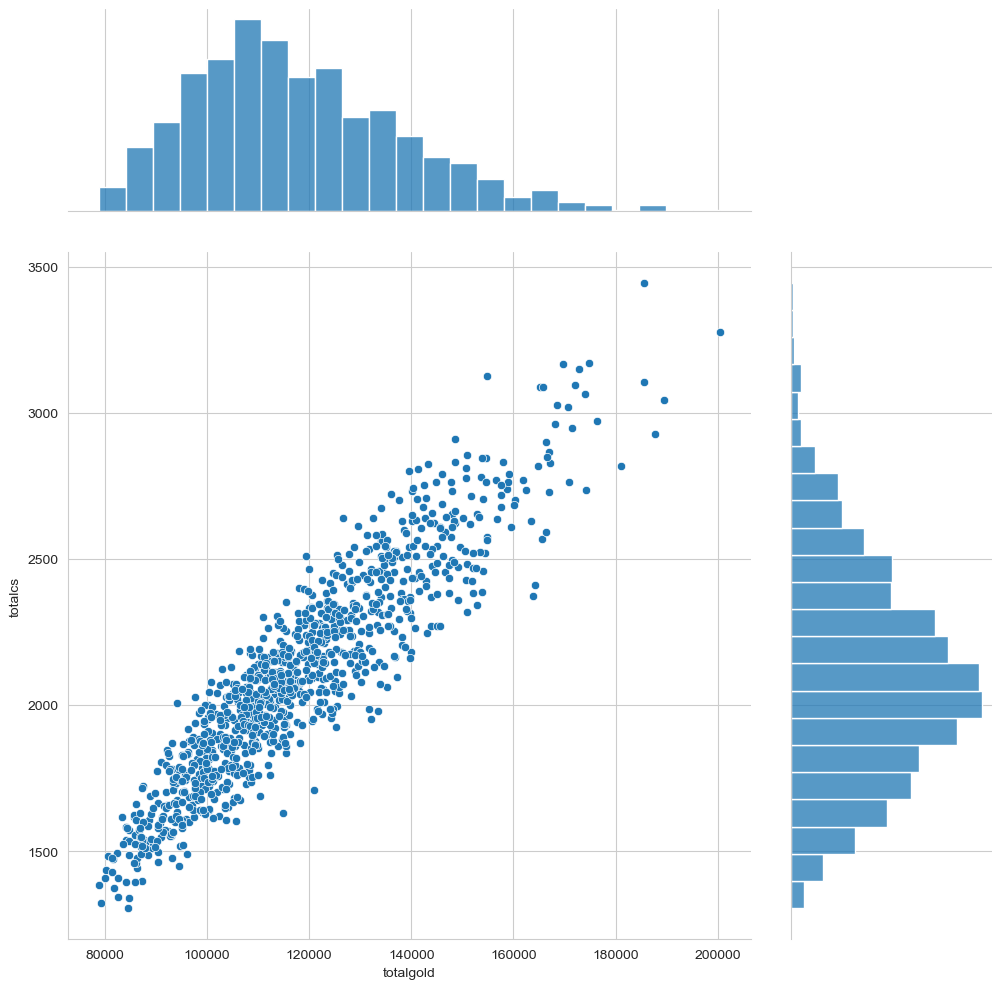

In [30]:
# Create a joint dataframe by concatenating the two variables
totalGoldDF = pd.concat([totalGoldEarned, totalCS], axis = 1).reindex(totalGoldEarned.index)

# Set the style of seaborn
sns.set_style("whitegrid")

# Create the jointplot with adjusted height and aspect ratio
sns.jointplot(data=totalGoldDF, x="totalgold", y="totalcs", height=10, ratio=3)

# Show the plot
plt.show()

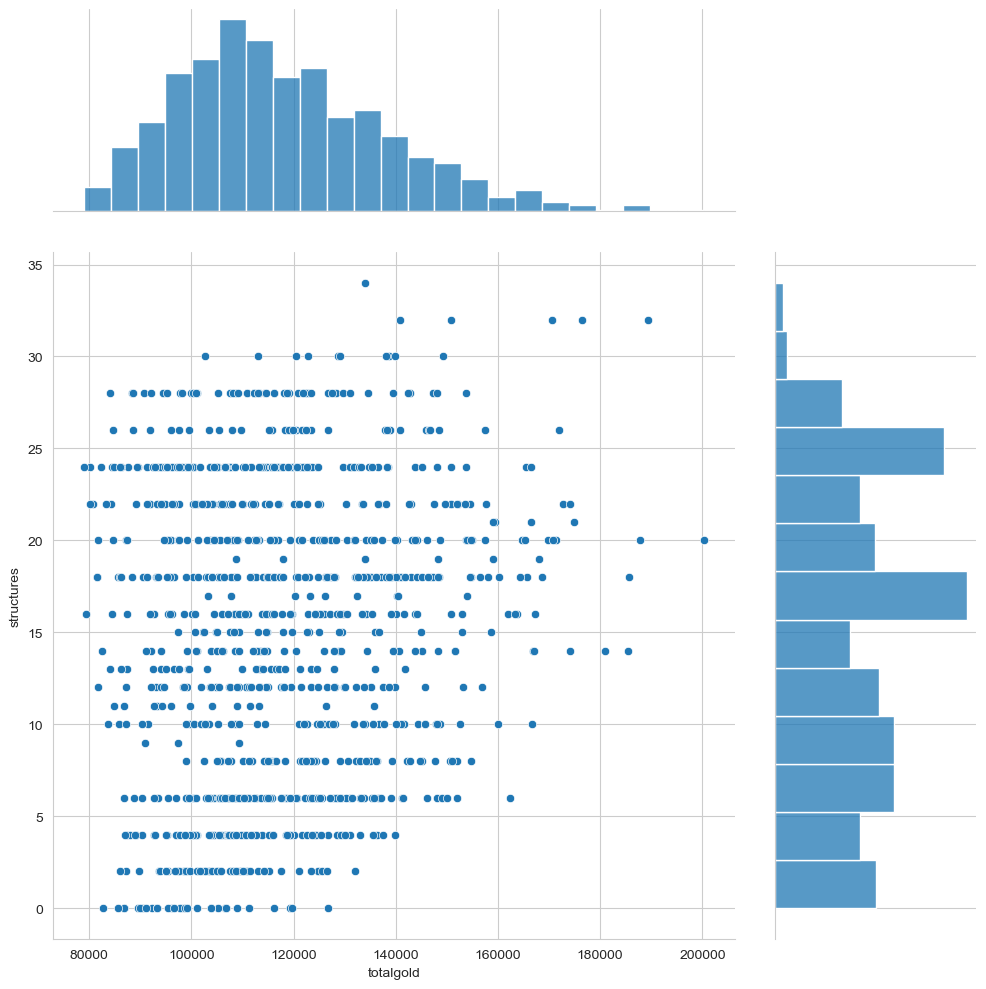

In [31]:
# Create a joint dataframe by concatenating the two variables
totalGoldDF = pd.concat([totalGoldEarned, structures], axis = 1).reindex(totalGoldEarned.index)

# Set the style of seaborn
sns.set_style("whitegrid")

# Create the jointplot with adjusted height and aspect ratio
sns.jointplot(data=totalGoldDF, x="totalgold", y="structures", height=10, ratio=3)

# Show the plot
plt.show()

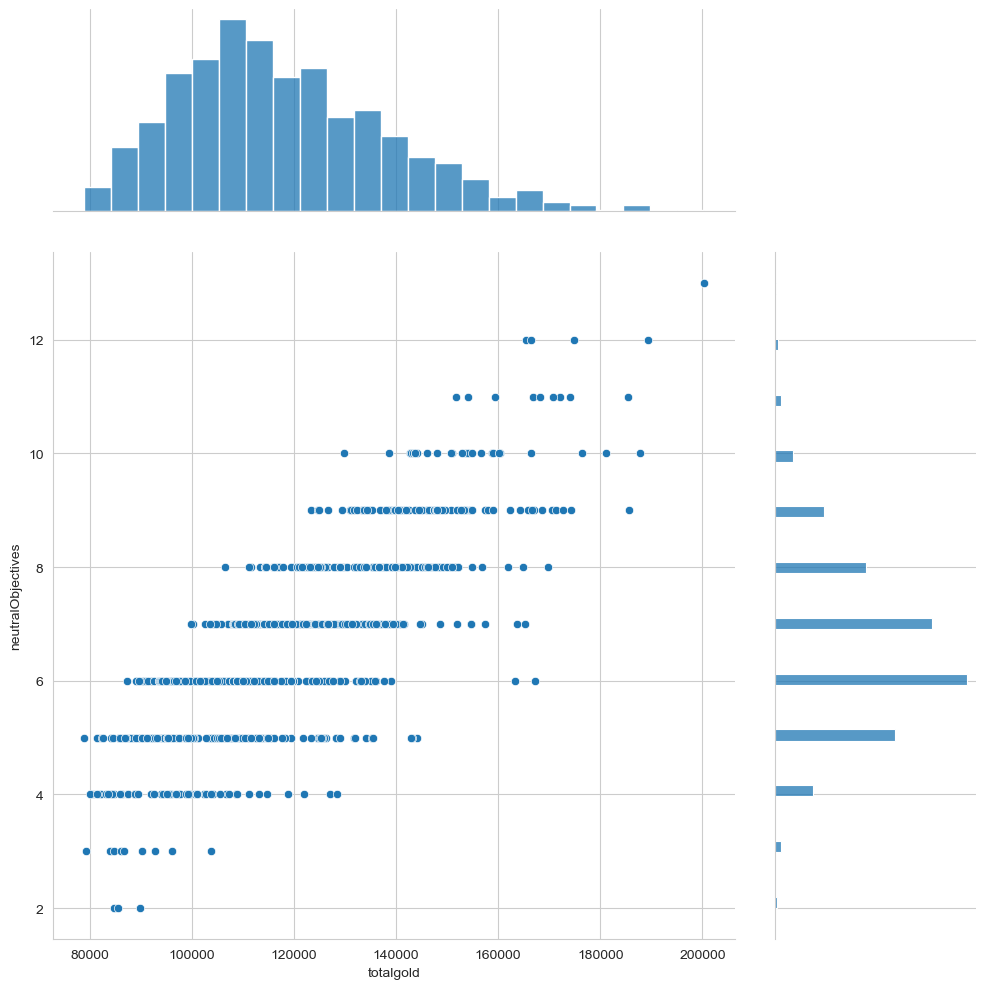

In [32]:
# Create a joint dataframe by concatenating the two variables
totalGoldDF = pd.concat([totalGoldEarned, neutral_Objectives], axis = 1).reindex(totalGoldEarned.index)

# Set the style of seaborn
sns.set_style("whitegrid")

# Create the jointplot with adjusted height and aspect ratio
sns.jointplot(data=totalGoldDF, x="totalgold", y="neutralObjectives", height=10, ratio=3)

# Show the plot
plt.show()

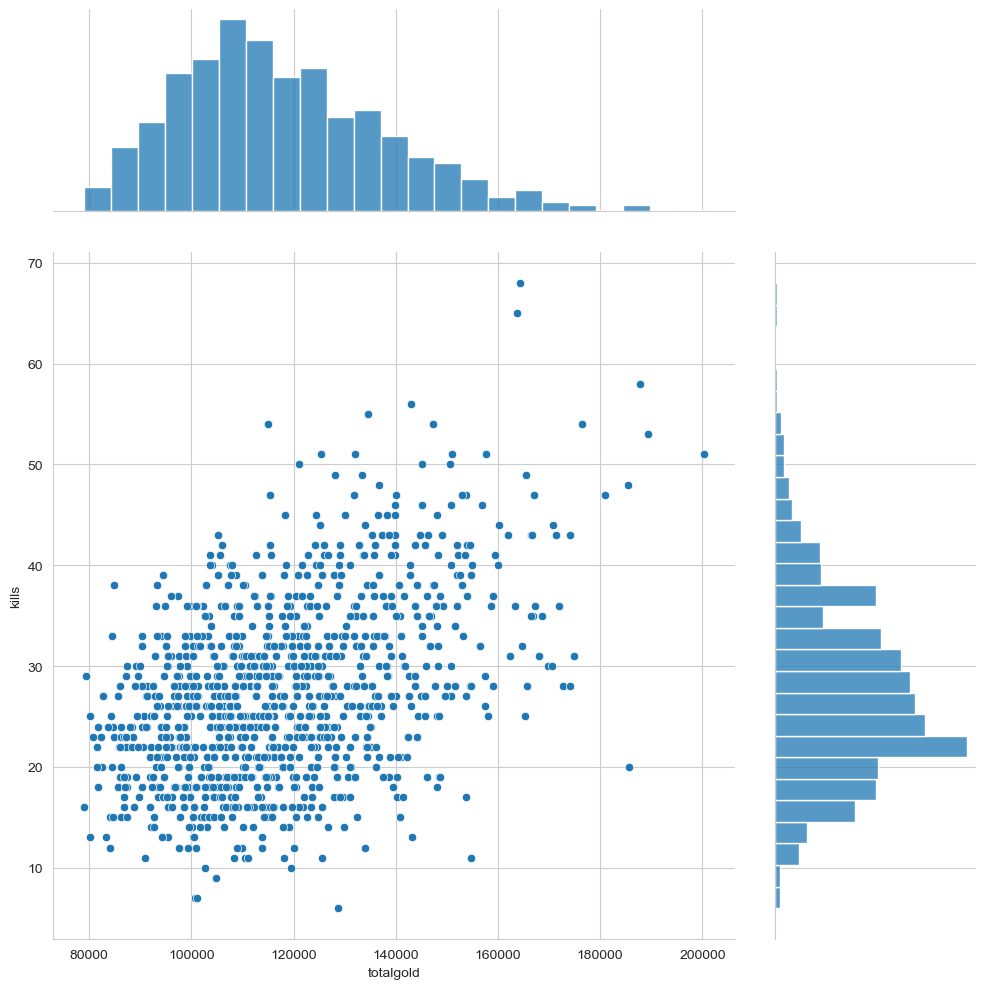

In [33]:
# Create a joint dataframe by concatenating the two variables
totalGoldDF = pd.concat([totalGoldEarned, Kills], axis = 1).reindex(totalGoldEarned.index)

# Set the style of seaborn
sns.set_style("whitegrid")

# Create the jointplot with adjusted height and aspect ratio
sns.jointplot(data=totalGoldDF, x="totalgold", y="kills", height=10, ratio=3)

# Show the plot
plt.show()

### Linear Regression

In [34]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Kills

Predict total gold earn using number of kills
- Predictor (X) : Kills
- Response (y) : totalGoldEarned

Intercept of Regression 	: b =  [88924.98932777]
Coefficients of Regression 	: a =  [[1040.7658112]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.2081394539847703
Mean Squared Error (MSE) 	: 336078853.00414205

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.22164853167319354
Mean Squared Error (MSE) 	: 290568723.1075773



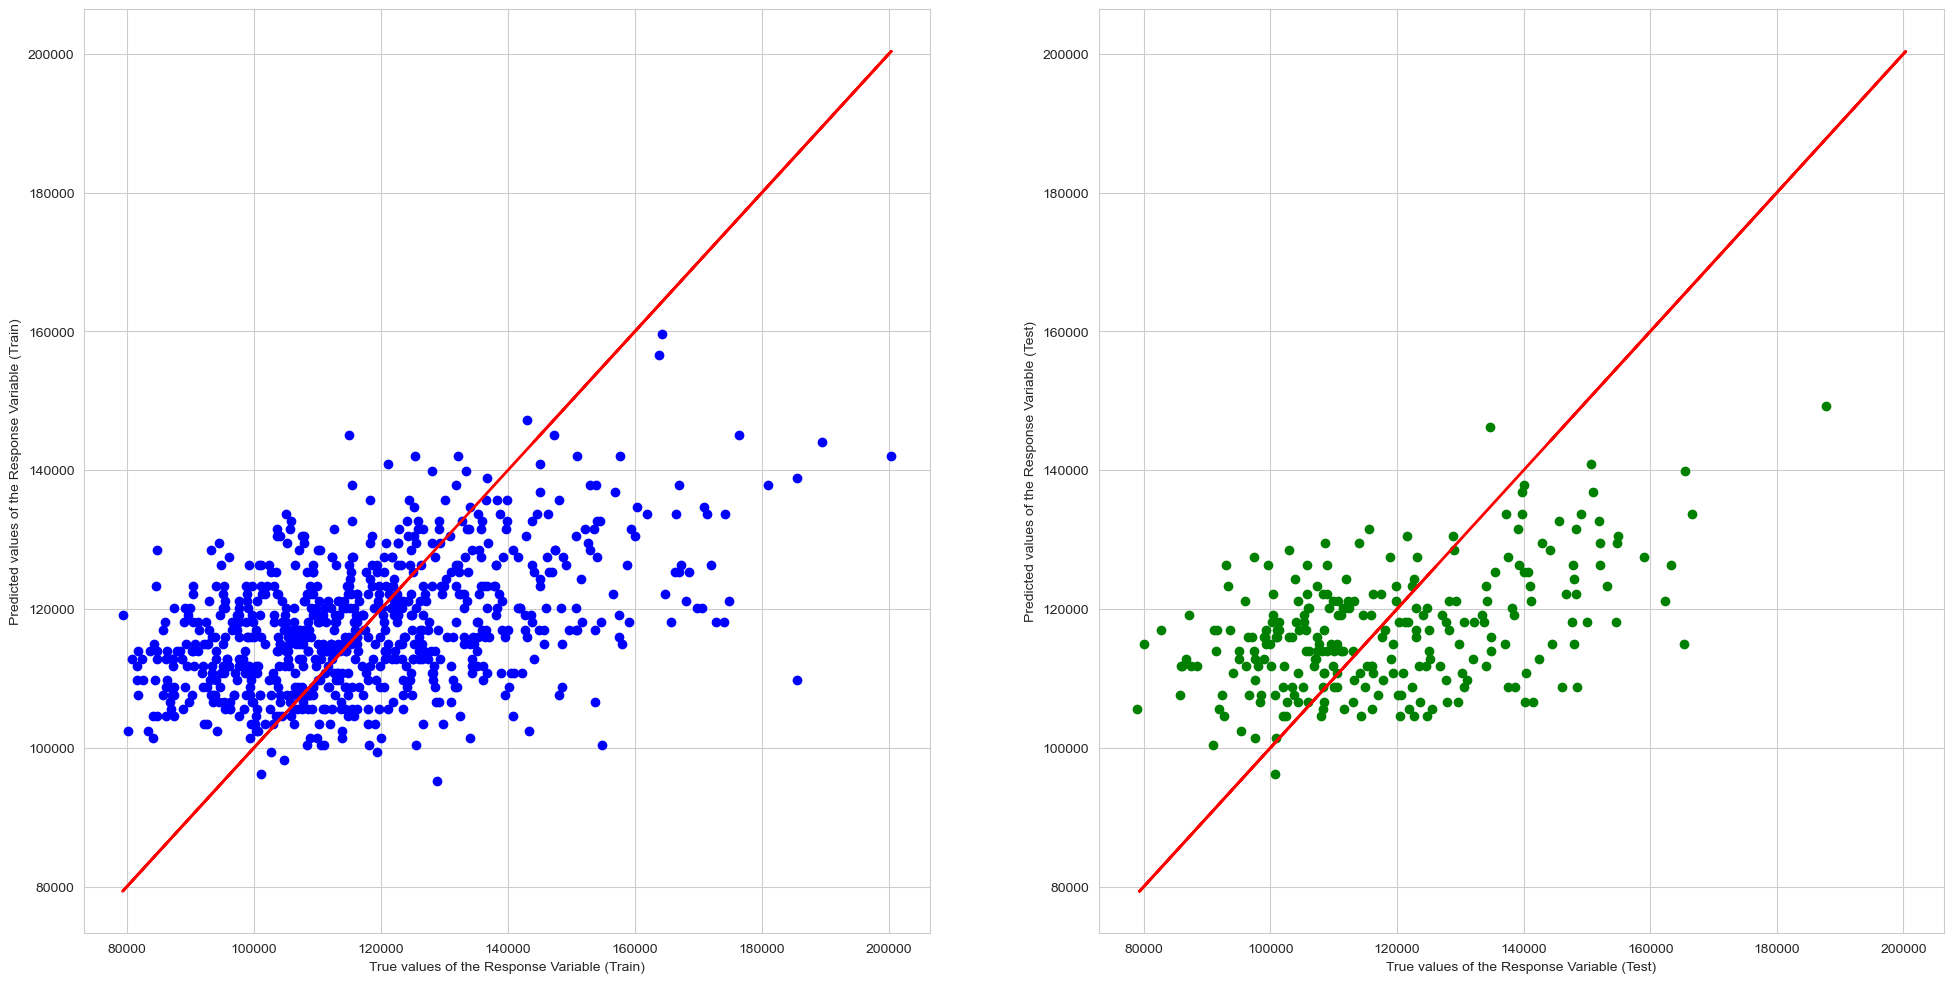

In [35]:
# Predictor (X) : Kills
# Response (y) : totalGoldEarned

X_train, X_test, y_train, y_test = train_test_split(Kills, totalGoldEarned, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Total values corresponding to HP
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, color = "red", linewidth = 2)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_train, y_train, color = "red", linewidth = 2)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

#### Total Creep Score

Predict total gold earn using total creep score
- Predictor (X) : totalCS
- Response (y) : totalGoldEarned

Intercept of Regression 	: b =  [7169.9595471]
Coefficients of Regression 	: a =  [[52.52519416]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.8416839544217399
Mean Squared Error (MSE) 	: 63159732.376888655

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8806306159908485
Mean Squared Error (MSE) 	: 53492373.62412341



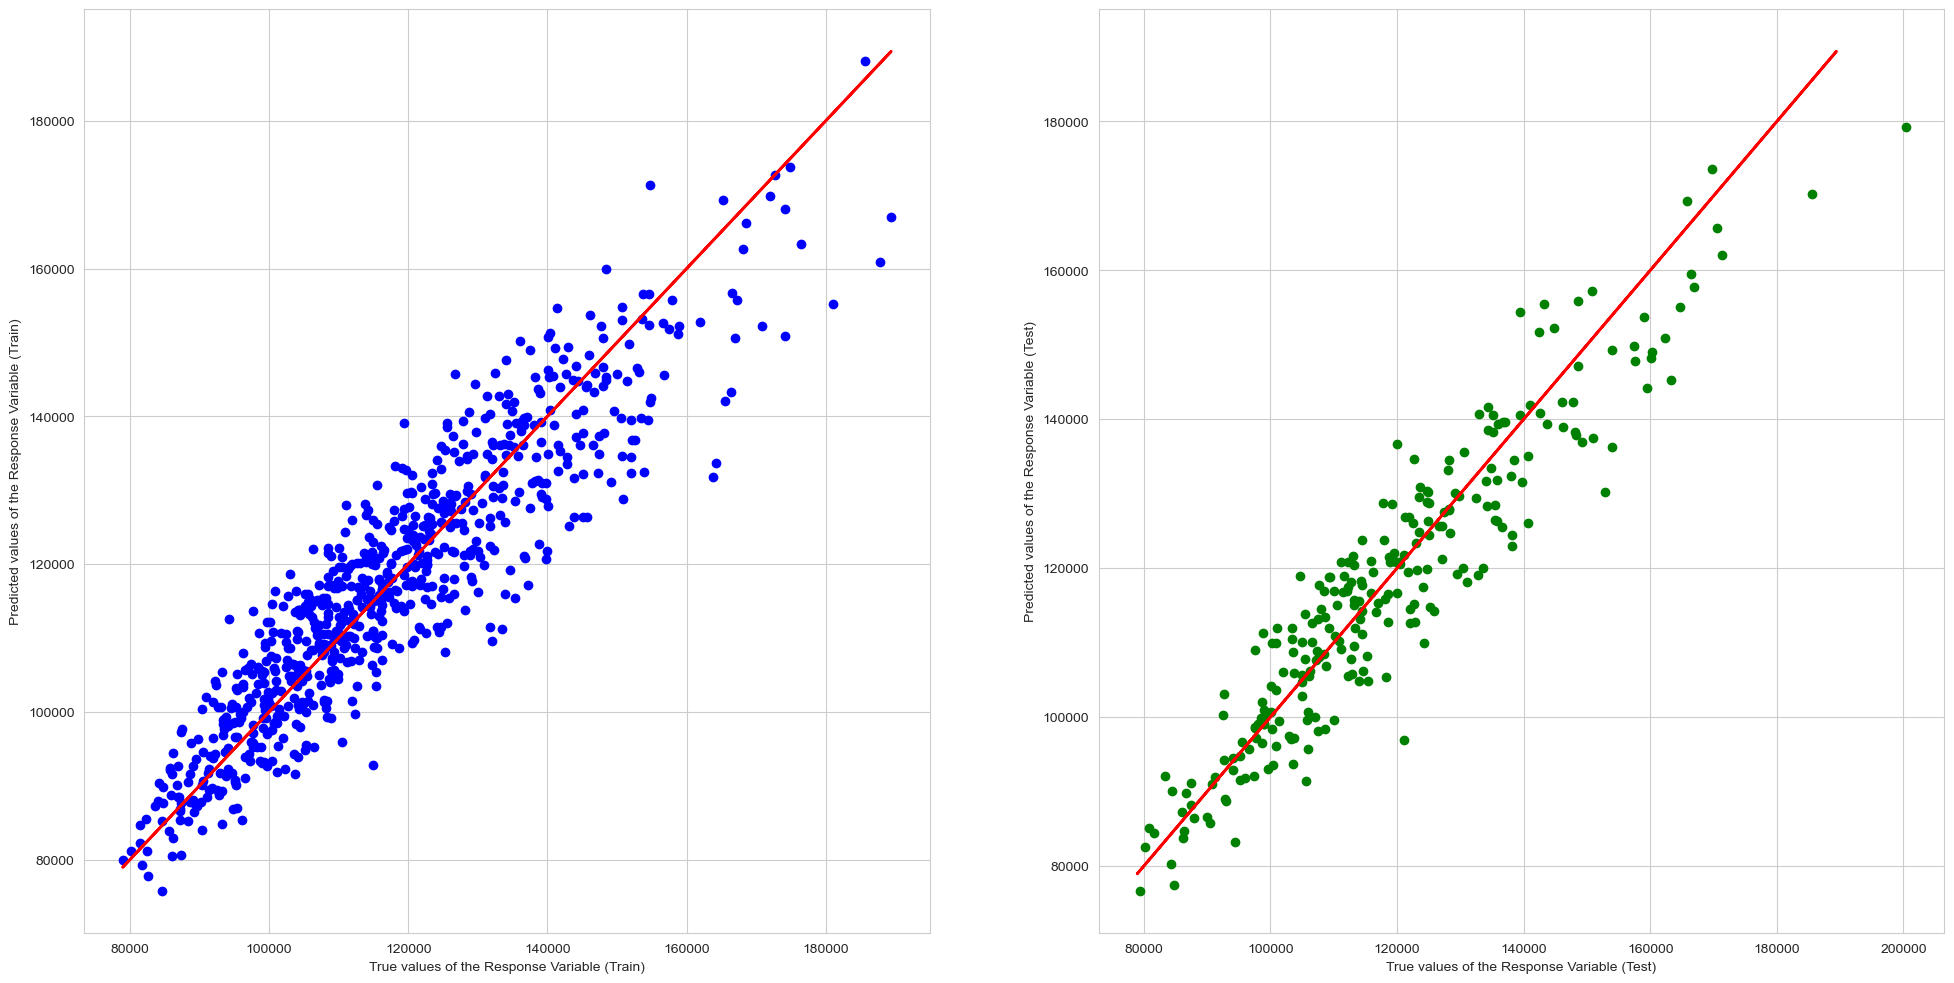

In [36]:
# Predictor (X) : totalCS
# Response (y) : totalGoldEarned

X_train, X_test, y_train, y_test = train_test_split(totalCS, totalGoldEarned, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Total values corresponding to HP
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, color = "red", linewidth = 2)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_train, y_train, color = "red", linewidth = 2)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

#### Neutral Objective

Predict total gold earn using total neutral objective
- Predictor (X) : neutral_Objectives
- Response (y) : totalGoldEarned

Intercept of Regression 	: b =  [50570.08302718]
Coefficients of Regression 	: a =  [[10215.43624615]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6316395416890239
Mean Squared Error (MSE) 	: 151325166.4741001

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6363771273728951
Mean Squared Error (MSE) 	: 150544013.9695757



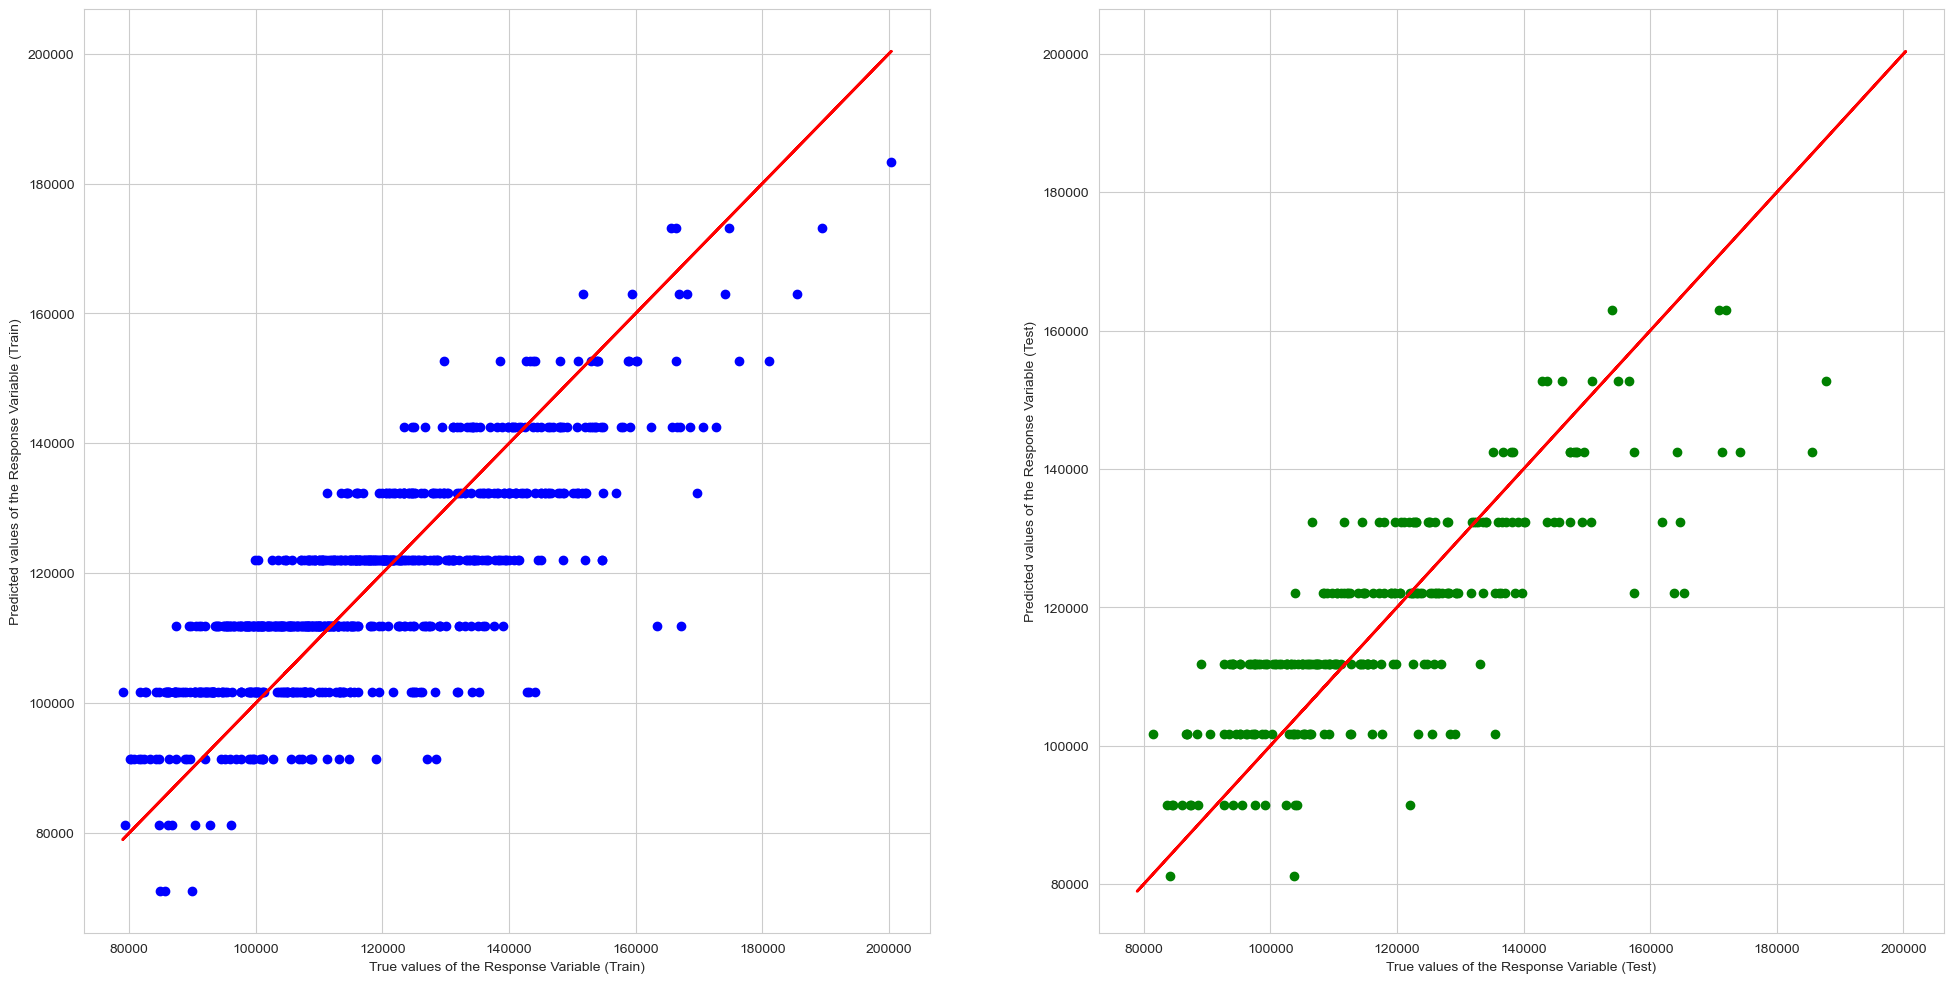

In [37]:
# Predictor (X) : neutral_Objectives
# Response (y) : totalGoldEarned

X_train, X_test, y_train, y_test = train_test_split(neutral_Objectives, totalGoldEarned, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Total values corresponding to HP
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, color = "red", linewidth = 2)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_train, y_train, color = "red", linewidth = 2)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

#### Structures

Predict total gold earn using structures
- Predictor (X) : structures
- Response (y) : totalGoldEarned

Intercept of Regression 	: b =  [112984.74430839]
Coefficients of Regression 	: a =  [[321.30401083]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.01686110028426091
Mean Squared Error (MSE) 	: 401557724.6198503

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.041632459769281205
Mean Squared Error (MSE) 	: 403555297.3278425



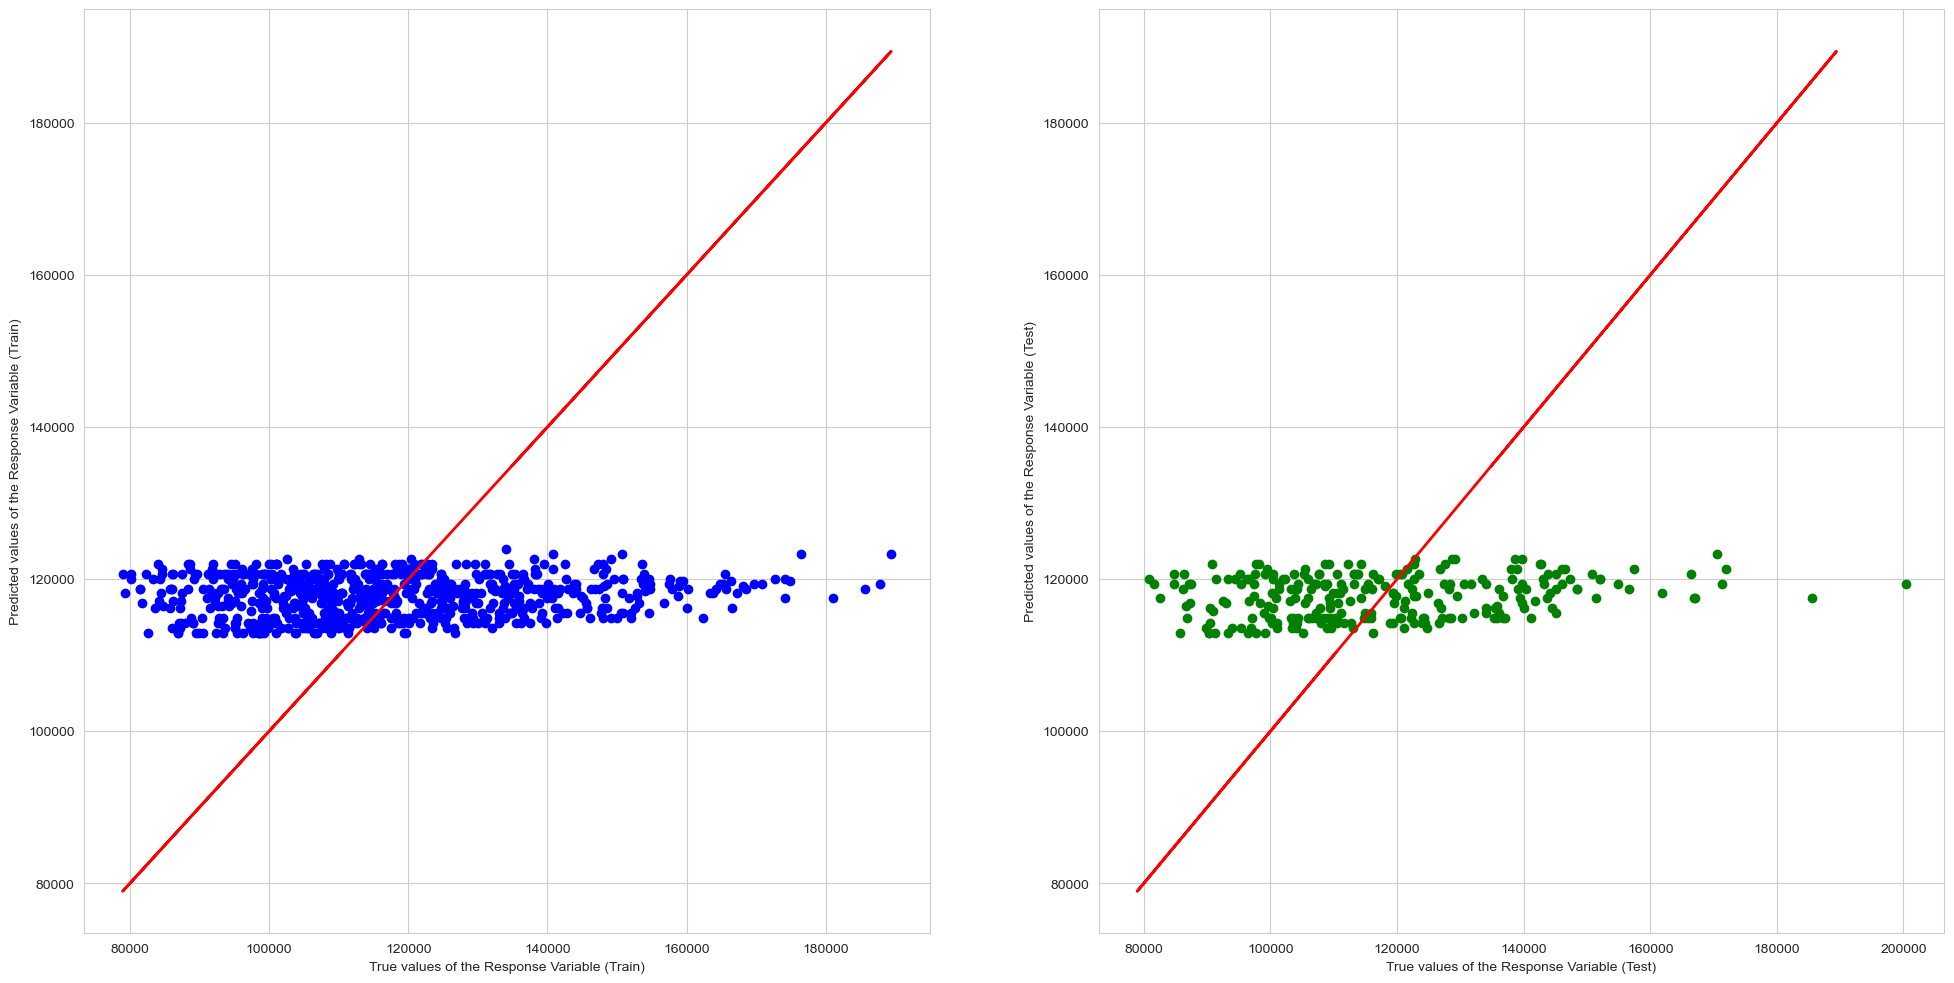

In [38]:
# Predictor (X) : structures
# Response (y) : totalGoldEarned

X_train, X_test, y_train, y_test = train_test_split(structures, totalGoldEarned, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Total values corresponding to HP
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, color = "red", linewidth = 2)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_train, y_train, color = "red", linewidth = 2)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()